In [1]:
# prepare packages
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Data_sets/MNIST_data')

Extracting ../Data_sets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-labels-idx1-ubyte.gz


# Network

In [3]:
# input placeholders
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [4]:
def generator(z, output_dim, reuse=False, initial_feature_size=512, alpha=0.2, is_training=True):
    with tf.variable_scope('generator', reuse=reuse):
        feature_map_size = initial_feature_size
        
        # 1. Fully connected layer (make 3x3x512)
        first_layer_units = 3 * 3 * feature_map_size
        x1 = tf.layers.dense(inputs=z, units=first_layer_units, activation=None, use_bias=True)
        # reshape as convolutional layer
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        # add batch normalization
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_training)
        # add reaky relu activation
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. convolutional layer (make 7x7x256)
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=feature_map_size, kernel_size=3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. convolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=feature_map_size, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer, 28x28x1
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=output_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

In [5]:
def discriminator(x, reuse=False, initial_filter_size=64, alpha=0.2, is_training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # starting variable
        filters = initial_filter_size
        # Input layer is 28x28x1
        
        # make 14x14x64
        x1 = tf.layers.conv2d(inputs=x, filters=filters, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # make 7x7x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, filters=filters, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, filters=filters, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattened_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattened_layer, units=1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

# Build

In [8]:
class DCGAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [9]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r', aspect='equal')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

# Train

In [10]:
def train(net, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for ii in range(mnist.train.num_examples//batch_size):
                steps += 1
                
                # no need labels
                batch_x, _ = mnist.train.next_batch(batch_size)
                
                # Get images rescale to pass to D
                batch_images = batch_x.reshape(-1, 28, 28, 1)
                batch_images = batch_images*2 -1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 1, reuse=True, is_training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

# Hyperparameters

In [11]:
real_size = (28,28,1)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 30
alpha = 0.2
beta1 = 0.5

# Create the network
net = DCGAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/30... Discriminator Loss: 0.4377... Generator Loss: 1.8888
Epoch 1/30... Discriminator Loss: 1.3422... Generator Loss: 5.0770
Epoch 1/30... Discriminator Loss: 0.4891... Generator Loss: 2.7544
Epoch 1/30... Discriminator Loss: 0.8670... Generator Loss: 0.9382
Epoch 1/30... Discriminator Loss: 0.4087... Generator Loss: 2.7907
Epoch 1/30... Discriminator Loss: 0.2937... Generator Loss: 2.0134
Epoch 1/30... Discriminator Loss: 0.5808... Generator Loss: 1.4386
Epoch 1/30... Discriminator Loss: 0.5263... Generator Loss: 2.5771
Epoch 1/30... Discriminator Loss: 0.7951... Generator Loss: 1.0222
Epoch 1/30... Discriminator Loss: 0.5035... Generator Loss: 1.5818


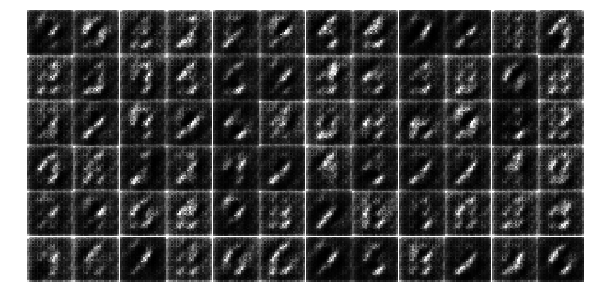

Epoch 1/30... Discriminator Loss: 0.5106... Generator Loss: 1.4179
Epoch 1/30... Discriminator Loss: 0.9318... Generator Loss: 0.8676
Epoch 1/30... Discriminator Loss: 0.8748... Generator Loss: 0.9260
Epoch 1/30... Discriminator Loss: 1.1706... Generator Loss: 2.0930
Epoch 1/30... Discriminator Loss: 0.6599... Generator Loss: 2.4764
Epoch 1/30... Discriminator Loss: 1.1919... Generator Loss: 0.5928
Epoch 1/30... Discriminator Loss: 0.6720... Generator Loss: 1.1222
Epoch 1/30... Discriminator Loss: 0.6358... Generator Loss: 1.2368
Epoch 1/30... Discriminator Loss: 0.9545... Generator Loss: 0.7659
Epoch 1/30... Discriminator Loss: 0.7008... Generator Loss: 1.3542


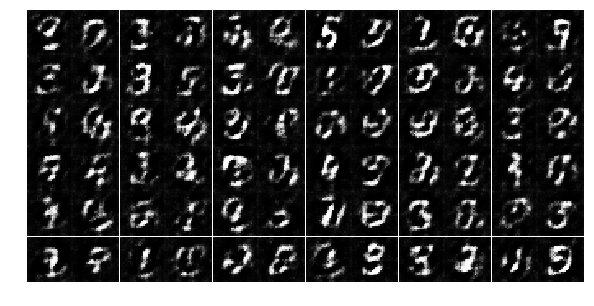

Epoch 1/30... Discriminator Loss: 1.2476... Generator Loss: 0.4818
Epoch 1/30... Discriminator Loss: 0.8934... Generator Loss: 2.7063
Epoch 1/30... Discriminator Loss: 1.1021... Generator Loss: 0.5500
Epoch 1/30... Discriminator Loss: 0.6703... Generator Loss: 1.8025
Epoch 1/30... Discriminator Loss: 0.7182... Generator Loss: 2.1436
Epoch 1/30... Discriminator Loss: 0.6469... Generator Loss: 1.4968
Epoch 1/30... Discriminator Loss: 0.6059... Generator Loss: 1.2668
Epoch 1/30... Discriminator Loss: 0.8245... Generator Loss: 1.0542
Epoch 1/30... Discriminator Loss: 0.7110... Generator Loss: 1.1009
Epoch 1/30... Discriminator Loss: 0.7903... Generator Loss: 2.4203


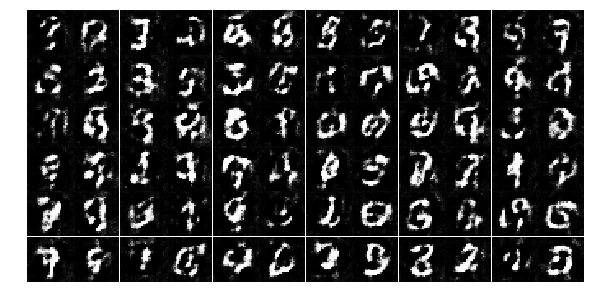

Epoch 1/30... Discriminator Loss: 0.6874... Generator Loss: 2.5341
Epoch 1/30... Discriminator Loss: 0.6356... Generator Loss: 2.4094
Epoch 1/30... Discriminator Loss: 0.7392... Generator Loss: 0.9223
Epoch 1/30... Discriminator Loss: 0.6613... Generator Loss: 2.1918
Epoch 1/30... Discriminator Loss: 0.5832... Generator Loss: 1.9921
Epoch 1/30... Discriminator Loss: 0.6599... Generator Loss: 2.1624
Epoch 1/30... Discriminator Loss: 0.6505... Generator Loss: 2.2038
Epoch 1/30... Discriminator Loss: 0.6156... Generator Loss: 1.1449
Epoch 1/30... Discriminator Loss: 0.6523... Generator Loss: 2.7710
Epoch 1/30... Discriminator Loss: 0.5476... Generator Loss: 1.2547


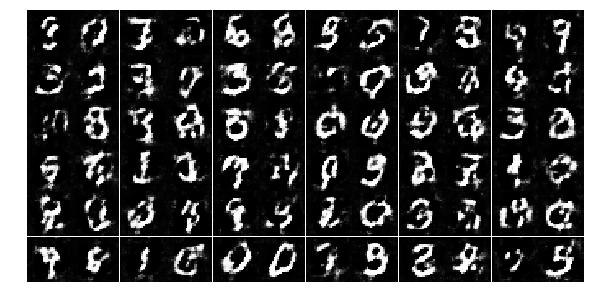

Epoch 1/30... Discriminator Loss: 0.9364... Generator Loss: 0.6553
Epoch 1/30... Discriminator Loss: 0.4883... Generator Loss: 1.5024
Epoch 2/30... Discriminator Loss: 0.5660... Generator Loss: 1.1450
Epoch 2/30... Discriminator Loss: 0.5523... Generator Loss: 1.7326
Epoch 2/30... Discriminator Loss: 0.5315... Generator Loss: 1.8242
Epoch 2/30... Discriminator Loss: 0.6169... Generator Loss: 1.0610
Epoch 2/30... Discriminator Loss: 0.5575... Generator Loss: 1.6387
Epoch 2/30... Discriminator Loss: 0.5018... Generator Loss: 1.5070
Epoch 2/30... Discriminator Loss: 2.0331... Generator Loss: 4.6503
Epoch 2/30... Discriminator Loss: 0.7009... Generator Loss: 0.9834


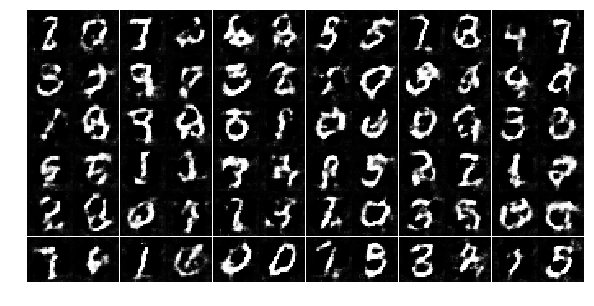

Epoch 2/30... Discriminator Loss: 0.7293... Generator Loss: 2.6695
Epoch 2/30... Discriminator Loss: 0.7618... Generator Loss: 2.3213
Epoch 2/30... Discriminator Loss: 0.6678... Generator Loss: 2.1433
Epoch 2/30... Discriminator Loss: 1.1086... Generator Loss: 3.1293
Epoch 2/30... Discriminator Loss: 0.6819... Generator Loss: 0.9741
Epoch 2/30... Discriminator Loss: 0.7568... Generator Loss: 2.2801
Epoch 2/30... Discriminator Loss: 0.6705... Generator Loss: 1.0165
Epoch 2/30... Discriminator Loss: 0.6571... Generator Loss: 1.1579
Epoch 2/30... Discriminator Loss: 0.7410... Generator Loss: 2.4311
Epoch 2/30... Discriminator Loss: 0.5649... Generator Loss: 2.0436


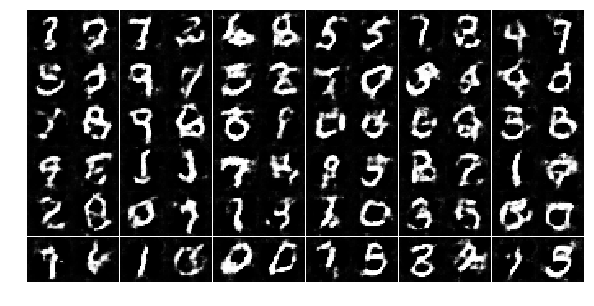

Epoch 2/30... Discriminator Loss: 1.0674... Generator Loss: 0.5552
Epoch 2/30... Discriminator Loss: 0.5281... Generator Loss: 1.3264
Epoch 2/30... Discriminator Loss: 0.6219... Generator Loss: 1.8757
Epoch 2/30... Discriminator Loss: 0.8281... Generator Loss: 0.7478
Epoch 2/30... Discriminator Loss: 0.7236... Generator Loss: 2.1716
Epoch 2/30... Discriminator Loss: 0.7499... Generator Loss: 0.8834
Epoch 2/30... Discriminator Loss: 1.0766... Generator Loss: 2.6860
Epoch 2/30... Discriminator Loss: 0.9045... Generator Loss: 0.6892
Epoch 2/30... Discriminator Loss: 0.7786... Generator Loss: 2.2240
Epoch 2/30... Discriminator Loss: 0.5980... Generator Loss: 1.7767


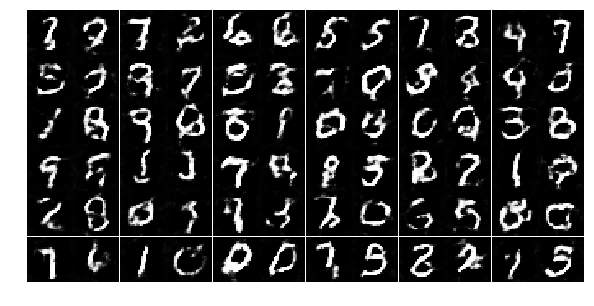

Epoch 2/30... Discriminator Loss: 0.8853... Generator Loss: 0.7994
Epoch 2/30... Discriminator Loss: 0.6177... Generator Loss: 1.2086
Epoch 2/30... Discriminator Loss: 0.6580... Generator Loss: 1.2021
Epoch 2/30... Discriminator Loss: 0.7186... Generator Loss: 1.9802
Epoch 2/30... Discriminator Loss: 0.9179... Generator Loss: 0.6583
Epoch 2/30... Discriminator Loss: 0.7372... Generator Loss: 2.4558
Epoch 2/30... Discriminator Loss: 0.6968... Generator Loss: 1.0128
Epoch 2/30... Discriminator Loss: 0.6210... Generator Loss: 1.3544
Epoch 2/30... Discriminator Loss: 1.0988... Generator Loss: 0.5271
Epoch 2/30... Discriminator Loss: 0.9328... Generator Loss: 0.6483


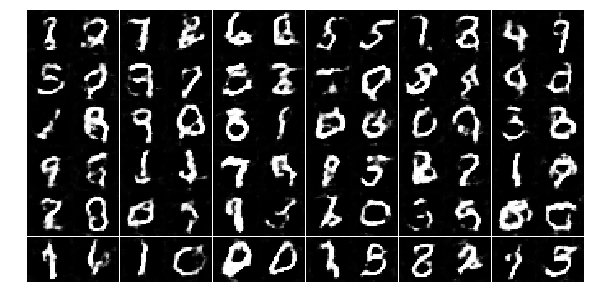

Epoch 2/30... Discriminator Loss: 0.8437... Generator Loss: 0.7843
Epoch 2/30... Discriminator Loss: 0.6489... Generator Loss: 2.0732
Epoch 2/30... Discriminator Loss: 0.9361... Generator Loss: 0.6671
Epoch 2/30... Discriminator Loss: 0.6509... Generator Loss: 1.4228
Epoch 2/30... Discriminator Loss: 1.0117... Generator Loss: 0.6600
Epoch 3/30... Discriminator Loss: 0.7079... Generator Loss: 0.9575
Epoch 3/30... Discriminator Loss: 0.7568... Generator Loss: 0.9601
Epoch 3/30... Discriminator Loss: 0.9021... Generator Loss: 2.6107
Epoch 3/30... Discriminator Loss: 0.5862... Generator Loss: 1.7188
Epoch 3/30... Discriminator Loss: 3.4396... Generator Loss: 4.7494


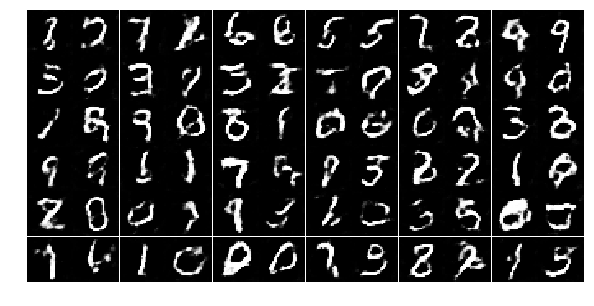

Epoch 3/30... Discriminator Loss: 0.6573... Generator Loss: 1.3903
Epoch 3/30... Discriminator Loss: 0.6392... Generator Loss: 1.2180
Epoch 3/30... Discriminator Loss: 0.5457... Generator Loss: 1.4888
Epoch 3/30... Discriminator Loss: 0.5951... Generator Loss: 1.2391
Epoch 3/30... Discriminator Loss: 0.7325... Generator Loss: 0.8867
Epoch 3/30... Discriminator Loss: 0.5350... Generator Loss: 1.7414
Epoch 3/30... Discriminator Loss: 1.1051... Generator Loss: 3.0897
Epoch 3/30... Discriminator Loss: 0.7734... Generator Loss: 0.8914
Epoch 3/30... Discriminator Loss: 0.6265... Generator Loss: 1.1478
Epoch 3/30... Discriminator Loss: 0.5513... Generator Loss: 1.4066


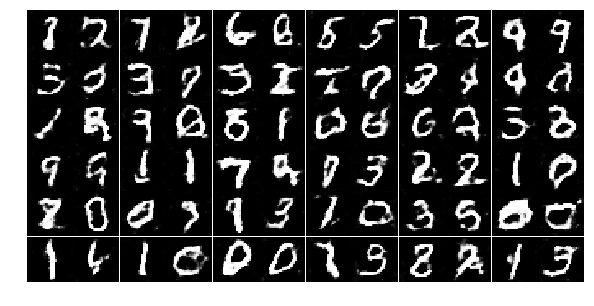

Epoch 3/30... Discriminator Loss: 0.5834... Generator Loss: 2.0790
Epoch 3/30... Discriminator Loss: 1.2960... Generator Loss: 0.4219
Epoch 3/30... Discriminator Loss: 0.5091... Generator Loss: 1.6193
Epoch 3/30... Discriminator Loss: 0.6290... Generator Loss: 1.0182
Epoch 3/30... Discriminator Loss: 0.5446... Generator Loss: 1.4237
Epoch 3/30... Discriminator Loss: 2.5471... Generator Loss: 0.1811
Epoch 3/30... Discriminator Loss: 0.7931... Generator Loss: 0.9015
Epoch 3/30... Discriminator Loss: 0.6260... Generator Loss: 1.1199
Epoch 3/30... Discriminator Loss: 0.5222... Generator Loss: 1.3322
Epoch 3/30... Discriminator Loss: 0.4893... Generator Loss: 1.4162


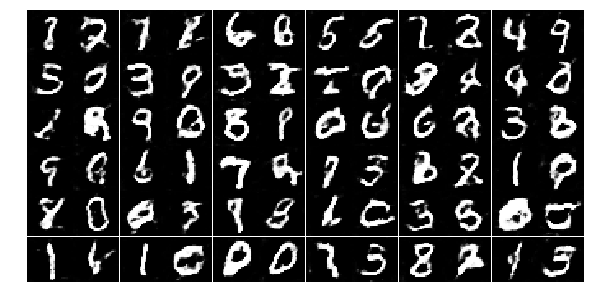

Epoch 3/30... Discriminator Loss: 1.5260... Generator Loss: 3.5473
Epoch 3/30... Discriminator Loss: 0.5962... Generator Loss: 1.1441
Epoch 3/30... Discriminator Loss: 0.4789... Generator Loss: 1.5602
Epoch 3/30... Discriminator Loss: 0.6945... Generator Loss: 0.9459
Epoch 3/30... Discriminator Loss: 1.0186... Generator Loss: 2.4608
Epoch 3/30... Discriminator Loss: 0.6719... Generator Loss: 1.0296
Epoch 3/30... Discriminator Loss: 0.5117... Generator Loss: 1.3466
Epoch 3/30... Discriminator Loss: 0.4271... Generator Loss: 1.6181
Epoch 3/30... Discriminator Loss: 0.6780... Generator Loss: 1.0266
Epoch 3/30... Discriminator Loss: 0.5431... Generator Loss: 1.3451


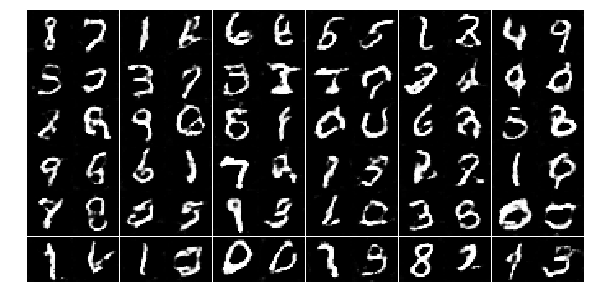

Epoch 3/30... Discriminator Loss: 1.4253... Generator Loss: 0.4459
Epoch 3/30... Discriminator Loss: 0.6869... Generator Loss: 1.5668
Epoch 3/30... Discriminator Loss: 0.6711... Generator Loss: 1.3060
Epoch 3/30... Discriminator Loss: 0.6122... Generator Loss: 1.4708
Epoch 3/30... Discriminator Loss: 0.5688... Generator Loss: 1.3417
Epoch 3/30... Discriminator Loss: 0.7154... Generator Loss: 0.9106
Epoch 3/30... Discriminator Loss: 0.6769... Generator Loss: 0.9961
Epoch 3/30... Discriminator Loss: 0.6743... Generator Loss: 0.9762
Epoch 4/30... Discriminator Loss: 0.5456... Generator Loss: 1.3709
Epoch 4/30... Discriminator Loss: 1.0815... Generator Loss: 0.5779


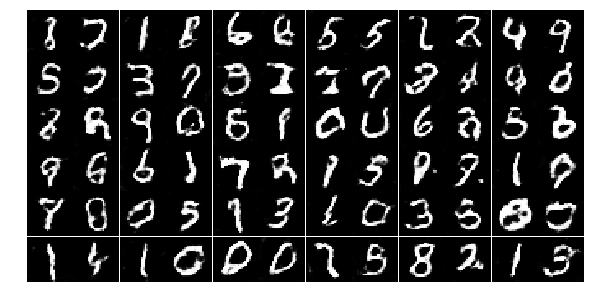

Epoch 4/30... Discriminator Loss: 0.7252... Generator Loss: 1.0220
Epoch 4/30... Discriminator Loss: 0.7661... Generator Loss: 0.8864
Epoch 4/30... Discriminator Loss: 2.3899... Generator Loss: 3.9531
Epoch 4/30... Discriminator Loss: 0.8878... Generator Loss: 1.2961
Epoch 4/30... Discriminator Loss: 0.6992... Generator Loss: 1.2805
Epoch 4/30... Discriminator Loss: 0.6188... Generator Loss: 1.1652
Epoch 4/30... Discriminator Loss: 0.5904... Generator Loss: 1.1798
Epoch 4/30... Discriminator Loss: 0.5331... Generator Loss: 1.7467
Epoch 4/30... Discriminator Loss: 1.4637... Generator Loss: 3.2485
Epoch 4/30... Discriminator Loss: 0.8835... Generator Loss: 1.1121


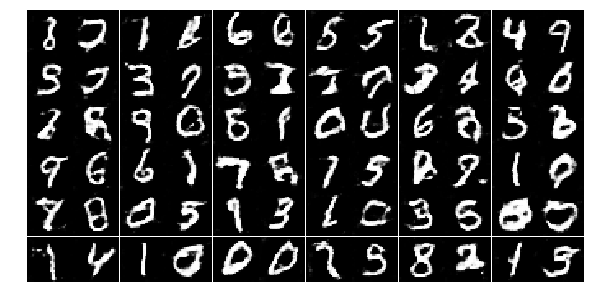

Epoch 4/30... Discriminator Loss: 0.6672... Generator Loss: 1.3829
Epoch 4/30... Discriminator Loss: 0.6151... Generator Loss: 1.2706
Epoch 4/30... Discriminator Loss: 0.6254... Generator Loss: 1.4423
Epoch 4/30... Discriminator Loss: 0.6278... Generator Loss: 1.8144
Epoch 4/30... Discriminator Loss: 0.7510... Generator Loss: 0.9042
Epoch 4/30... Discriminator Loss: 0.5974... Generator Loss: 1.3090
Epoch 4/30... Discriminator Loss: 0.6878... Generator Loss: 1.0156
Epoch 4/30... Discriminator Loss: 0.6920... Generator Loss: 1.0495
Epoch 4/30... Discriminator Loss: 0.9378... Generator Loss: 0.7123
Epoch 4/30... Discriminator Loss: 0.7964... Generator Loss: 0.9988


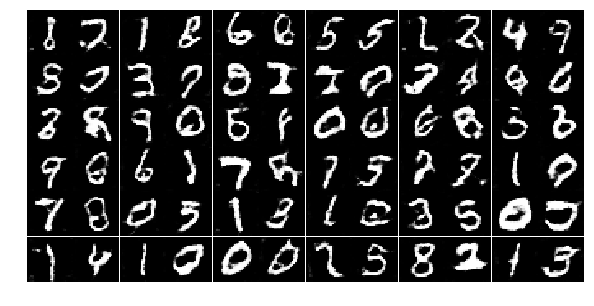

Epoch 4/30... Discriminator Loss: 0.8323... Generator Loss: 0.8463
Epoch 4/30... Discriminator Loss: 0.6917... Generator Loss: 1.1127
Epoch 4/30... Discriminator Loss: 0.7949... Generator Loss: 0.8702
Epoch 4/30... Discriminator Loss: 0.6792... Generator Loss: 1.0438
Epoch 4/30... Discriminator Loss: 0.7863... Generator Loss: 0.8611
Epoch 4/30... Discriminator Loss: 1.7492... Generator Loss: 0.4200
Epoch 4/30... Discriminator Loss: 0.6112... Generator Loss: 1.4118
Epoch 4/30... Discriminator Loss: 0.6924... Generator Loss: 1.3177
Epoch 4/30... Discriminator Loss: 0.7541... Generator Loss: 0.9330
Epoch 4/30... Discriminator Loss: 0.8315... Generator Loss: 2.5446


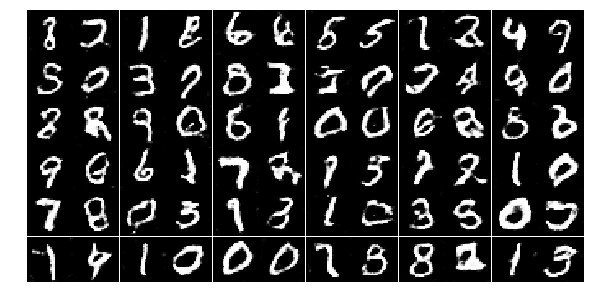

Epoch 4/30... Discriminator Loss: 1.7025... Generator Loss: 0.2822
Epoch 4/30... Discriminator Loss: 0.6731... Generator Loss: 1.2217
Epoch 4/30... Discriminator Loss: 0.6080... Generator Loss: 1.0898
Epoch 4/30... Discriminator Loss: 0.5080... Generator Loss: 1.5410
Epoch 4/30... Discriminator Loss: 0.6184... Generator Loss: 1.2757
Epoch 4/30... Discriminator Loss: 0.8181... Generator Loss: 0.8944
Epoch 4/30... Discriminator Loss: 0.7517... Generator Loss: 1.0383
Epoch 4/30... Discriminator Loss: 0.6027... Generator Loss: 1.1901
Epoch 4/30... Discriminator Loss: 0.6608... Generator Loss: 1.1828
Epoch 4/30... Discriminator Loss: 1.0590... Generator Loss: 0.5882


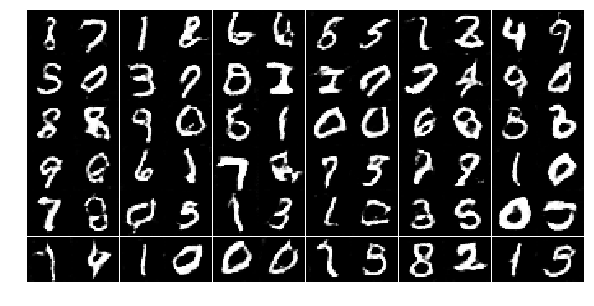

Epoch 4/30... Discriminator Loss: 1.2107... Generator Loss: 1.8963
Epoch 5/30... Discriminator Loss: 0.6340... Generator Loss: 1.0927
Epoch 5/30... Discriminator Loss: 0.6295... Generator Loss: 1.9047
Epoch 5/30... Discriminator Loss: 0.5580... Generator Loss: 1.3373
Epoch 5/30... Discriminator Loss: 0.6935... Generator Loss: 1.0358
Epoch 5/30... Discriminator Loss: 0.5620... Generator Loss: 1.2954
Epoch 5/30... Discriminator Loss: 0.9450... Generator Loss: 0.6508
Epoch 5/30... Discriminator Loss: 2.3699... Generator Loss: 0.2774
Epoch 5/30... Discriminator Loss: 0.6635... Generator Loss: 1.0702
Epoch 5/30... Discriminator Loss: 0.7691... Generator Loss: 0.9496


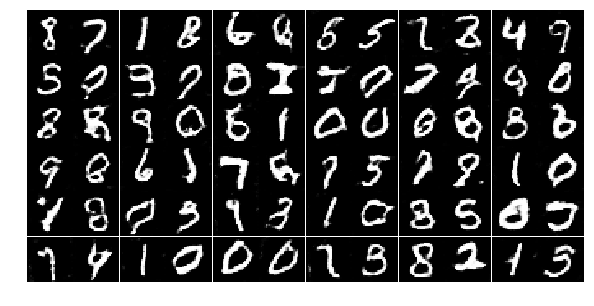

Epoch 5/30... Discriminator Loss: 1.7874... Generator Loss: 0.2612
Epoch 5/30... Discriminator Loss: 0.6676... Generator Loss: 1.0558
Epoch 5/30... Discriminator Loss: 0.7016... Generator Loss: 0.9915
Epoch 5/30... Discriminator Loss: 0.7513... Generator Loss: 0.8714
Epoch 5/30... Discriminator Loss: 0.8830... Generator Loss: 0.7928
Epoch 5/30... Discriminator Loss: 0.7811... Generator Loss: 2.2280
Epoch 5/30... Discriminator Loss: 1.3749... Generator Loss: 2.5883
Epoch 5/30... Discriminator Loss: 0.7235... Generator Loss: 1.1147
Epoch 5/30... Discriminator Loss: 0.6890... Generator Loss: 1.7855
Epoch 5/30... Discriminator Loss: 0.9609... Generator Loss: 0.6831


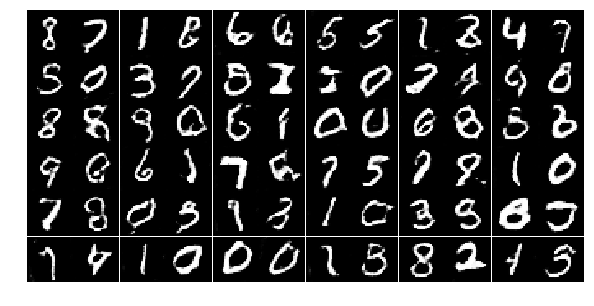

Epoch 5/30... Discriminator Loss: 0.7312... Generator Loss: 1.0670
Epoch 5/30... Discriminator Loss: 0.5439... Generator Loss: 1.2142
Epoch 5/30... Discriminator Loss: 1.2030... Generator Loss: 0.4949
Epoch 5/30... Discriminator Loss: 0.9171... Generator Loss: 0.7535
Epoch 5/30... Discriminator Loss: 0.7552... Generator Loss: 1.1014
Epoch 5/30... Discriminator Loss: 0.6340... Generator Loss: 1.2548
Epoch 5/30... Discriminator Loss: 0.9049... Generator Loss: 0.8338
Epoch 5/30... Discriminator Loss: 1.1766... Generator Loss: 1.8030
Epoch 5/30... Discriminator Loss: 0.8879... Generator Loss: 0.8188
Epoch 5/30... Discriminator Loss: 0.7253... Generator Loss: 1.0552


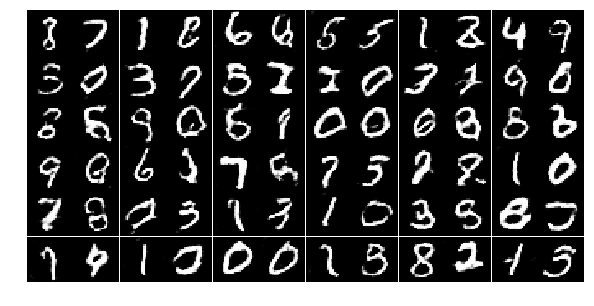

Epoch 5/30... Discriminator Loss: 0.6828... Generator Loss: 1.1912
Epoch 5/30... Discriminator Loss: 0.7133... Generator Loss: 1.1601
Epoch 5/30... Discriminator Loss: 0.6559... Generator Loss: 1.1401
Epoch 5/30... Discriminator Loss: 0.7560... Generator Loss: 1.0658
Epoch 5/30... Discriminator Loss: 0.7572... Generator Loss: 0.9780
Epoch 5/30... Discriminator Loss: 0.7476... Generator Loss: 0.8817
Epoch 5/30... Discriminator Loss: 0.5072... Generator Loss: 1.3219
Epoch 5/30... Discriminator Loss: 0.5508... Generator Loss: 1.8972
Epoch 5/30... Discriminator Loss: 0.8293... Generator Loss: 0.8091
Epoch 5/30... Discriminator Loss: 0.7531... Generator Loss: 0.9091


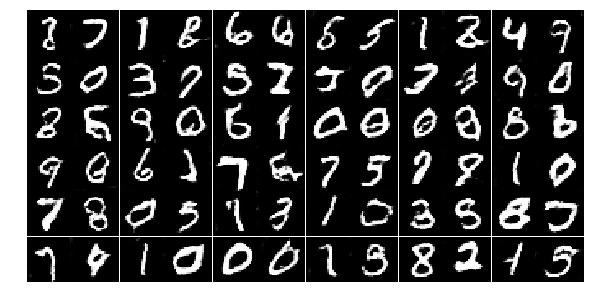

Epoch 5/30... Discriminator Loss: 1.1770... Generator Loss: 0.5442
Epoch 5/30... Discriminator Loss: 0.5351... Generator Loss: 1.2314
Epoch 5/30... Discriminator Loss: 0.5760... Generator Loss: 1.5145
Epoch 5/30... Discriminator Loss: 0.6496... Generator Loss: 1.5660
Epoch 6/30... Discriminator Loss: 0.7487... Generator Loss: 0.9668
Epoch 6/30... Discriminator Loss: 0.5700... Generator Loss: 1.6088
Epoch 6/30... Discriminator Loss: 0.8221... Generator Loss: 1.8839
Epoch 6/30... Discriminator Loss: 1.1054... Generator Loss: 0.6467
Epoch 6/30... Discriminator Loss: 0.8121... Generator Loss: 0.9138
Epoch 6/30... Discriminator Loss: 1.1305... Generator Loss: 0.6130


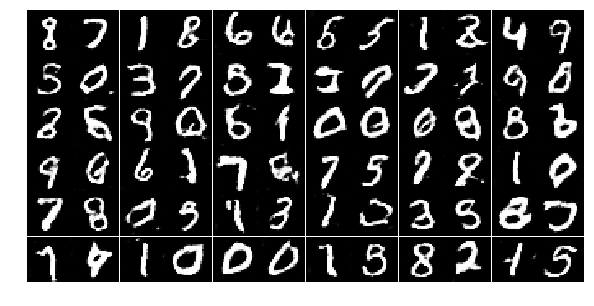

Epoch 6/30... Discriminator Loss: 0.5842... Generator Loss: 1.4617
Epoch 6/30... Discriminator Loss: 0.9516... Generator Loss: 0.6608
Epoch 6/30... Discriminator Loss: 0.5616... Generator Loss: 1.6074
Epoch 6/30... Discriminator Loss: 1.1687... Generator Loss: 0.5319
Epoch 6/30... Discriminator Loss: 0.8558... Generator Loss: 1.0077
Epoch 6/30... Discriminator Loss: 0.8815... Generator Loss: 0.9361
Epoch 6/30... Discriminator Loss: 0.7007... Generator Loss: 1.0058
Epoch 6/30... Discriminator Loss: 0.7589... Generator Loss: 0.9529
Epoch 6/30... Discriminator Loss: 0.9115... Generator Loss: 0.6978
Epoch 6/30... Discriminator Loss: 1.0199... Generator Loss: 0.6778


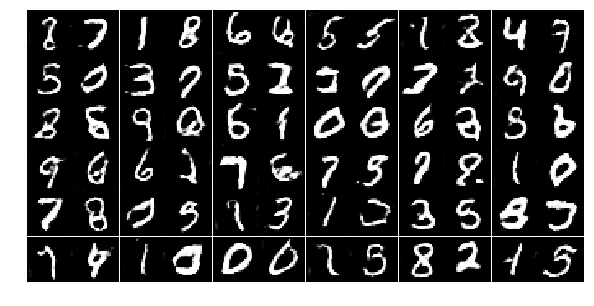

Epoch 6/30... Discriminator Loss: 0.6753... Generator Loss: 1.0434
Epoch 6/30... Discriminator Loss: 0.5805... Generator Loss: 1.2976
Epoch 6/30... Discriminator Loss: 0.5962... Generator Loss: 1.7200
Epoch 6/30... Discriminator Loss: 1.0782... Generator Loss: 0.5982
Epoch 6/30... Discriminator Loss: 1.1165... Generator Loss: 0.5844
Epoch 6/30... Discriminator Loss: 0.6827... Generator Loss: 1.0643
Epoch 6/30... Discriminator Loss: 0.7483... Generator Loss: 0.9641
Epoch 6/30... Discriminator Loss: 0.7646... Generator Loss: 0.8833
Epoch 6/30... Discriminator Loss: 1.4924... Generator Loss: 0.3836
Epoch 6/30... Discriminator Loss: 0.7220... Generator Loss: 1.4124


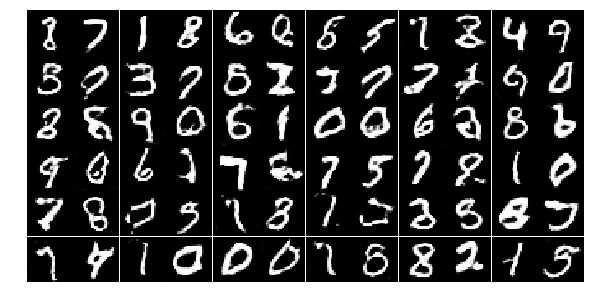

Epoch 6/30... Discriminator Loss: 1.0645... Generator Loss: 0.6140
Epoch 6/30... Discriminator Loss: 0.6275... Generator Loss: 1.1105
Epoch 6/30... Discriminator Loss: 0.9953... Generator Loss: 2.4614
Epoch 6/30... Discriminator Loss: 0.5997... Generator Loss: 1.4361
Epoch 6/30... Discriminator Loss: 0.8752... Generator Loss: 0.7441
Epoch 6/30... Discriminator Loss: 0.6177... Generator Loss: 1.2063
Epoch 6/30... Discriminator Loss: 0.5704... Generator Loss: 2.3805
Epoch 6/30... Discriminator Loss: 1.0146... Generator Loss: 0.6282
Epoch 6/30... Discriminator Loss: 0.6259... Generator Loss: 1.2235
Epoch 6/30... Discriminator Loss: 0.7362... Generator Loss: 0.9093


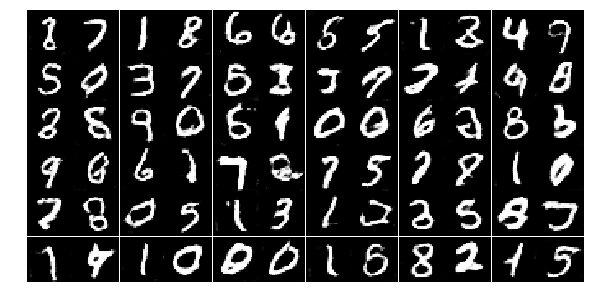

Epoch 6/30... Discriminator Loss: 0.7487... Generator Loss: 1.6224
Epoch 6/30... Discriminator Loss: 0.9440... Generator Loss: 0.6646
Epoch 6/30... Discriminator Loss: 1.3277... Generator Loss: 2.4284
Epoch 6/30... Discriminator Loss: 0.9960... Generator Loss: 0.8103
Epoch 6/30... Discriminator Loss: 1.0252... Generator Loss: 1.6747
Epoch 6/30... Discriminator Loss: 0.8073... Generator Loss: 1.8330
Epoch 6/30... Discriminator Loss: 0.7665... Generator Loss: 1.0963
Epoch 7/30... Discriminator Loss: 1.1097... Generator Loss: 0.6182
Epoch 7/30... Discriminator Loss: 0.7712... Generator Loss: 1.0775
Epoch 7/30... Discriminator Loss: 1.0961... Generator Loss: 0.6229


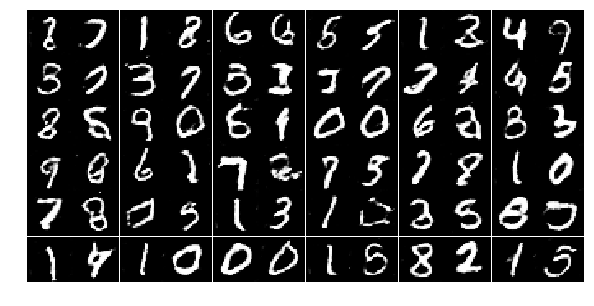

Epoch 7/30... Discriminator Loss: 0.9853... Generator Loss: 0.6360
Epoch 7/30... Discriminator Loss: 0.8190... Generator Loss: 0.8038
Epoch 7/30... Discriminator Loss: 0.7467... Generator Loss: 0.9471
Epoch 7/30... Discriminator Loss: 0.5531... Generator Loss: 1.4516
Epoch 7/30... Discriminator Loss: 0.7034... Generator Loss: 1.0130
Epoch 7/30... Discriminator Loss: 1.1364... Generator Loss: 2.8791
Epoch 7/30... Discriminator Loss: 0.6746... Generator Loss: 1.7287
Epoch 7/30... Discriminator Loss: 0.7083... Generator Loss: 1.3736
Epoch 7/30... Discriminator Loss: 0.7231... Generator Loss: 1.1295
Epoch 7/30... Discriminator Loss: 0.5555... Generator Loss: 1.5684


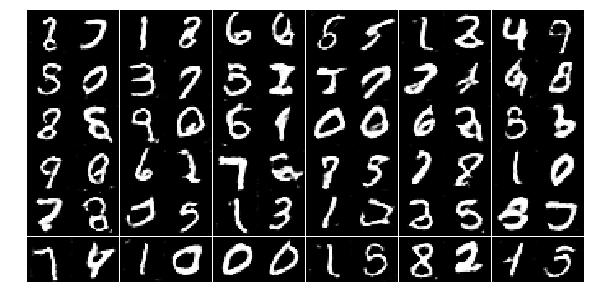

Epoch 7/30... Discriminator Loss: 1.2196... Generator Loss: 0.4922
Epoch 7/30... Discriminator Loss: 0.7038... Generator Loss: 1.1202
Epoch 7/30... Discriminator Loss: 0.7045... Generator Loss: 1.0764
Epoch 7/30... Discriminator Loss: 0.6927... Generator Loss: 1.1779
Epoch 7/30... Discriminator Loss: 0.7013... Generator Loss: 1.0619
Epoch 7/30... Discriminator Loss: 0.7541... Generator Loss: 1.0240
Epoch 7/30... Discriminator Loss: 1.0254... Generator Loss: 0.6278
Epoch 7/30... Discriminator Loss: 0.6351... Generator Loss: 1.5439
Epoch 7/30... Discriminator Loss: 0.6391... Generator Loss: 1.1091
Epoch 7/30... Discriminator Loss: 0.5153... Generator Loss: 1.3236


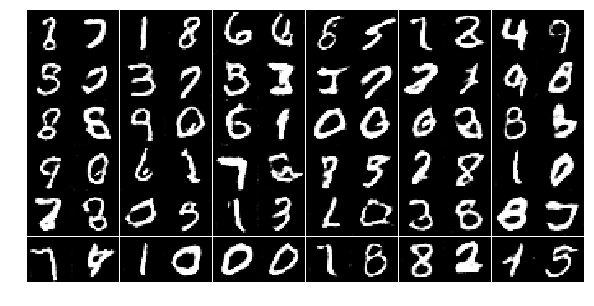

Epoch 7/30... Discriminator Loss: 0.8066... Generator Loss: 2.1653
Epoch 7/30... Discriminator Loss: 0.9438... Generator Loss: 0.7556
Epoch 7/30... Discriminator Loss: 0.6349... Generator Loss: 1.0228
Epoch 7/30... Discriminator Loss: 0.6203... Generator Loss: 1.5486
Epoch 7/30... Discriminator Loss: 1.2452... Generator Loss: 3.5757
Epoch 7/30... Discriminator Loss: 1.1316... Generator Loss: 0.5701
Epoch 7/30... Discriminator Loss: 0.6719... Generator Loss: 1.0230
Epoch 7/30... Discriminator Loss: 0.8541... Generator Loss: 2.8253
Epoch 7/30... Discriminator Loss: 0.9507... Generator Loss: 0.8373
Epoch 7/30... Discriminator Loss: 0.7707... Generator Loss: 1.5103


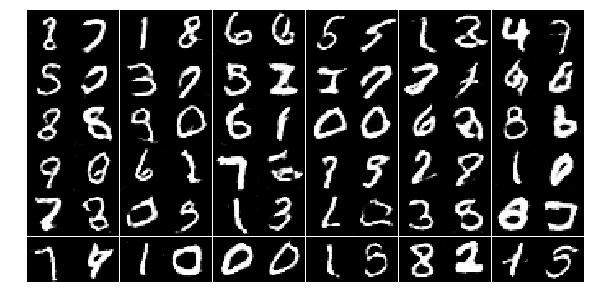

Epoch 7/30... Discriminator Loss: 0.6452... Generator Loss: 1.1839
Epoch 7/30... Discriminator Loss: 0.5259... Generator Loss: 1.4710
Epoch 7/30... Discriminator Loss: 0.7560... Generator Loss: 0.9541
Epoch 7/30... Discriminator Loss: 0.7519... Generator Loss: 0.9355
Epoch 7/30... Discriminator Loss: 1.1078... Generator Loss: 0.5538
Epoch 7/30... Discriminator Loss: 0.7697... Generator Loss: 0.9357
Epoch 7/30... Discriminator Loss: 0.4995... Generator Loss: 1.6166
Epoch 7/30... Discriminator Loss: 0.7225... Generator Loss: 0.9483
Epoch 7/30... Discriminator Loss: 0.8593... Generator Loss: 0.8223
Epoch 7/30... Discriminator Loss: 0.6988... Generator Loss: 1.0189


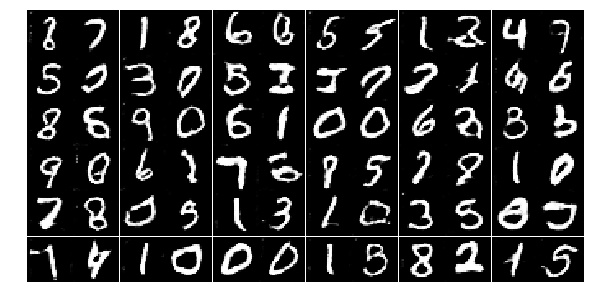

Epoch 8/30... Discriminator Loss: 0.7352... Generator Loss: 1.0414
Epoch 8/30... Discriminator Loss: 0.6023... Generator Loss: 1.2635
Epoch 8/30... Discriminator Loss: 0.8613... Generator Loss: 0.8785
Epoch 8/30... Discriminator Loss: 1.7982... Generator Loss: 3.0840
Epoch 8/30... Discriminator Loss: 0.9137... Generator Loss: 0.8318
Epoch 8/30... Discriminator Loss: 0.9620... Generator Loss: 0.7682
Epoch 8/30... Discriminator Loss: 1.0663... Generator Loss: 0.6547
Epoch 8/30... Discriminator Loss: 0.7267... Generator Loss: 2.1064
Epoch 8/30... Discriminator Loss: 0.6400... Generator Loss: 1.3811
Epoch 8/30... Discriminator Loss: 0.7314... Generator Loss: 0.8984


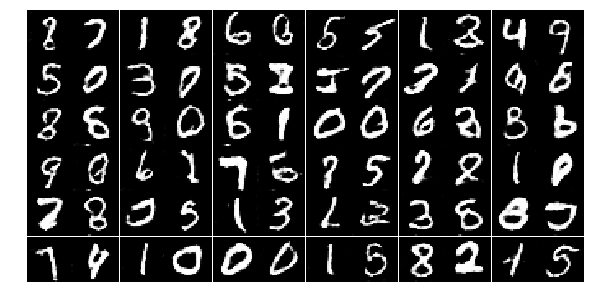

Epoch 8/30... Discriminator Loss: 0.6905... Generator Loss: 1.1865
Epoch 8/30... Discriminator Loss: 2.2938... Generator Loss: 4.6040
Epoch 8/30... Discriminator Loss: 0.7327... Generator Loss: 1.2737
Epoch 8/30... Discriminator Loss: 0.9751... Generator Loss: 0.6860
Epoch 8/30... Discriminator Loss: 0.5650... Generator Loss: 1.3360
Epoch 8/30... Discriminator Loss: 1.0432... Generator Loss: 2.0021
Epoch 8/30... Discriminator Loss: 0.8335... Generator Loss: 1.7282
Epoch 8/30... Discriminator Loss: 0.7202... Generator Loss: 1.0495
Epoch 8/30... Discriminator Loss: 0.7202... Generator Loss: 1.8114
Epoch 8/30... Discriminator Loss: 0.8031... Generator Loss: 1.0401


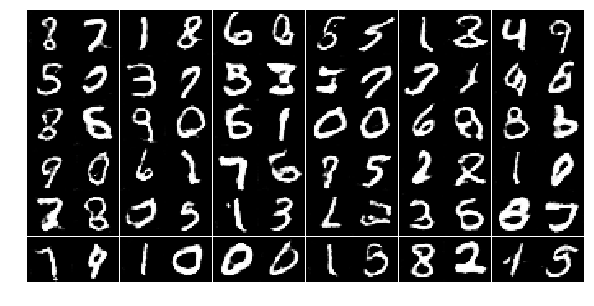

Epoch 8/30... Discriminator Loss: 0.7103... Generator Loss: 1.2448
Epoch 8/30... Discriminator Loss: 0.7162... Generator Loss: 1.4270
Epoch 8/30... Discriminator Loss: 0.6454... Generator Loss: 1.3773
Epoch 8/30... Discriminator Loss: 0.8858... Generator Loss: 0.9807
Epoch 8/30... Discriminator Loss: 0.9957... Generator Loss: 0.7026
Epoch 8/30... Discriminator Loss: 1.2810... Generator Loss: 0.4490
Epoch 8/30... Discriminator Loss: 0.8424... Generator Loss: 0.8619
Epoch 8/30... Discriminator Loss: 0.9221... Generator Loss: 0.7358
Epoch 8/30... Discriminator Loss: 0.5359... Generator Loss: 1.5426
Epoch 8/30... Discriminator Loss: 0.6449... Generator Loss: 1.0593


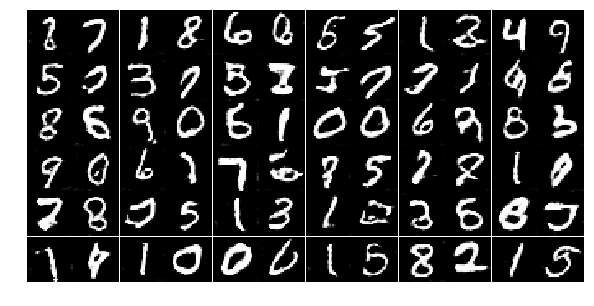

Epoch 8/30... Discriminator Loss: 0.7571... Generator Loss: 2.9582
Epoch 8/30... Discriminator Loss: 1.3927... Generator Loss: 0.4113
Epoch 8/30... Discriminator Loss: 0.9106... Generator Loss: 0.9905
Epoch 8/30... Discriminator Loss: 0.7865... Generator Loss: 1.0387
Epoch 8/30... Discriminator Loss: 1.1648... Generator Loss: 0.5616
Epoch 8/30... Discriminator Loss: 0.6351... Generator Loss: 1.2589
Epoch 8/30... Discriminator Loss: 0.5766... Generator Loss: 1.4757
Epoch 8/30... Discriminator Loss: 0.9630... Generator Loss: 0.6968
Epoch 8/30... Discriminator Loss: 0.9218... Generator Loss: 0.7275
Epoch 8/30... Discriminator Loss: 0.7508... Generator Loss: 0.9153


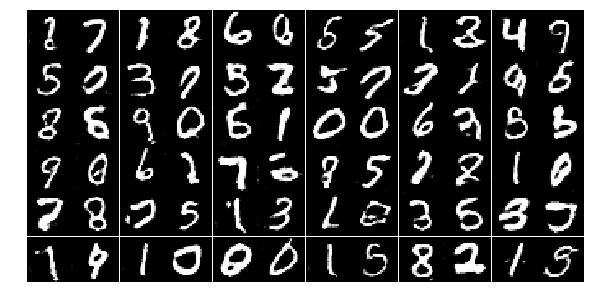

Epoch 8/30... Discriminator Loss: 0.5685... Generator Loss: 1.4171
Epoch 8/30... Discriminator Loss: 1.0417... Generator Loss: 0.6632
Epoch 8/30... Discriminator Loss: 0.7017... Generator Loss: 0.9867
Epoch 9/30... Discriminator Loss: 1.3435... Generator Loss: 0.4153
Epoch 9/30... Discriminator Loss: 0.7152... Generator Loss: 0.9550
Epoch 9/30... Discriminator Loss: 0.6920... Generator Loss: 1.0069
Epoch 9/30... Discriminator Loss: 0.6375... Generator Loss: 1.1618
Epoch 9/30... Discriminator Loss: 0.6445... Generator Loss: 1.0872
Epoch 9/30... Discriminator Loss: 0.9073... Generator Loss: 0.7896
Epoch 9/30... Discriminator Loss: 0.8531... Generator Loss: 0.8356


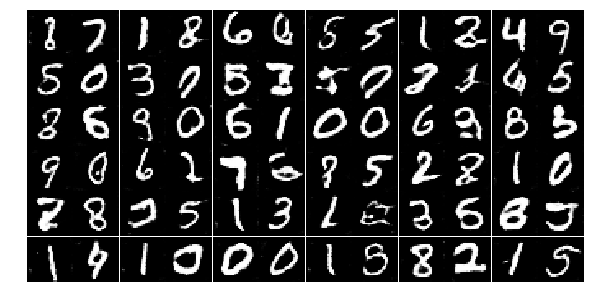

Epoch 9/30... Discriminator Loss: 0.7537... Generator Loss: 0.9290
Epoch 9/30... Discriminator Loss: 0.6246... Generator Loss: 1.2642
Epoch 9/30... Discriminator Loss: 0.4660... Generator Loss: 1.6884
Epoch 9/30... Discriminator Loss: 0.7309... Generator Loss: 1.0080
Epoch 9/30... Discriminator Loss: 0.7620... Generator Loss: 0.8771
Epoch 9/30... Discriminator Loss: 0.9849... Generator Loss: 0.7172
Epoch 9/30... Discriminator Loss: 0.5714... Generator Loss: 1.3685
Epoch 9/30... Discriminator Loss: 0.8016... Generator Loss: 0.8883
Epoch 9/30... Discriminator Loss: 1.0315... Generator Loss: 0.6665
Epoch 9/30... Discriminator Loss: 0.6678... Generator Loss: 1.7351


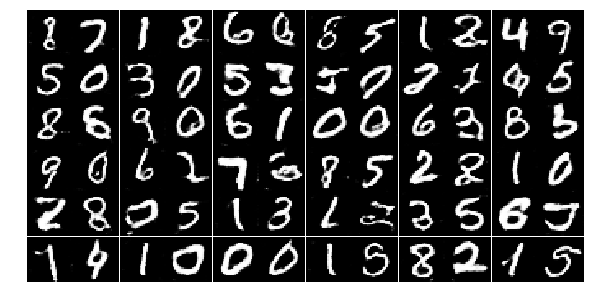

Epoch 9/30... Discriminator Loss: 0.7711... Generator Loss: 1.5229
Epoch 9/30... Discriminator Loss: 0.5612... Generator Loss: 1.6466
Epoch 9/30... Discriminator Loss: 0.5858... Generator Loss: 1.3323
Epoch 9/30... Discriminator Loss: 0.5911... Generator Loss: 1.7401
Epoch 9/30... Discriminator Loss: 0.6899... Generator Loss: 1.1296
Epoch 9/30... Discriminator Loss: 0.7628... Generator Loss: 0.8794
Epoch 9/30... Discriminator Loss: 0.5855... Generator Loss: 1.5138
Epoch 9/30... Discriminator Loss: 0.9921... Generator Loss: 0.6542
Epoch 9/30... Discriminator Loss: 0.6346... Generator Loss: 1.1677
Epoch 9/30... Discriminator Loss: 0.5907... Generator Loss: 1.3972


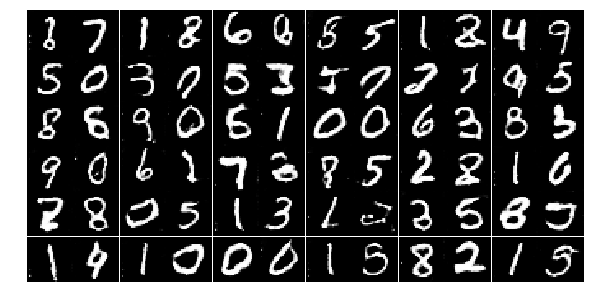

Epoch 9/30... Discriminator Loss: 0.4872... Generator Loss: 1.7822
Epoch 9/30... Discriminator Loss: 0.4803... Generator Loss: 1.5290
Epoch 9/30... Discriminator Loss: 1.3517... Generator Loss: 0.4371
Epoch 9/30... Discriminator Loss: 0.5968... Generator Loss: 1.0953
Epoch 9/30... Discriminator Loss: 0.5978... Generator Loss: 1.5123
Epoch 9/30... Discriminator Loss: 0.5353... Generator Loss: 1.5604
Epoch 9/30... Discriminator Loss: 1.0098... Generator Loss: 0.6360
Epoch 9/30... Discriminator Loss: 0.5691... Generator Loss: 1.2219
Epoch 9/30... Discriminator Loss: 1.6462... Generator Loss: 4.0657
Epoch 9/30... Discriminator Loss: 0.9761... Generator Loss: 0.6878


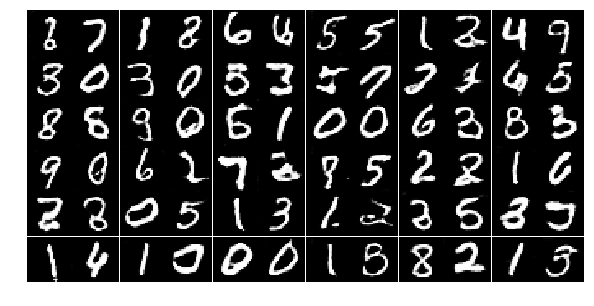

Epoch 9/30... Discriminator Loss: 0.6890... Generator Loss: 1.1020
Epoch 9/30... Discriminator Loss: 1.0861... Generator Loss: 3.0104
Epoch 9/30... Discriminator Loss: 1.5706... Generator Loss: 0.4089
Epoch 9/30... Discriminator Loss: 0.7759... Generator Loss: 0.9279
Epoch 9/30... Discriminator Loss: 0.7241... Generator Loss: 0.9488
Epoch 9/30... Discriminator Loss: 0.8297... Generator Loss: 0.8275
Epoch 10/30... Discriminator Loss: 0.8659... Generator Loss: 1.0158
Epoch 10/30... Discriminator Loss: 1.0266... Generator Loss: 0.6297
Epoch 10/30... Discriminator Loss: 1.0915... Generator Loss: 2.7184
Epoch 10/30... Discriminator Loss: 0.6107... Generator Loss: 1.2436


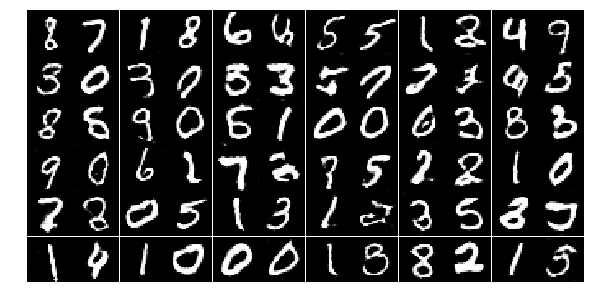

Epoch 10/30... Discriminator Loss: 1.2257... Generator Loss: 0.5572
Epoch 10/30... Discriminator Loss: 0.7562... Generator Loss: 1.1545
Epoch 10/30... Discriminator Loss: 0.5540... Generator Loss: 1.4951
Epoch 10/30... Discriminator Loss: 0.7127... Generator Loss: 1.0135
Epoch 10/30... Discriminator Loss: 0.7788... Generator Loss: 0.9179
Epoch 10/30... Discriminator Loss: 0.4393... Generator Loss: 1.6179
Epoch 10/30... Discriminator Loss: 0.5624... Generator Loss: 1.2385
Epoch 10/30... Discriminator Loss: 0.8921... Generator Loss: 0.7341
Epoch 10/30... Discriminator Loss: 0.7182... Generator Loss: 1.0112
Epoch 10/30... Discriminator Loss: 0.6033... Generator Loss: 1.2687


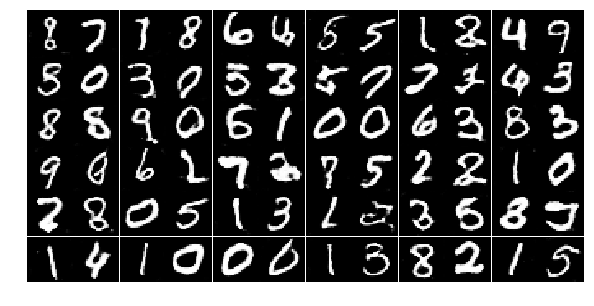

Epoch 10/30... Discriminator Loss: 0.7036... Generator Loss: 1.0651
Epoch 10/30... Discriminator Loss: 0.6883... Generator Loss: 1.1978
Epoch 10/30... Discriminator Loss: 1.2434... Generator Loss: 0.5046
Epoch 10/30... Discriminator Loss: 0.6648... Generator Loss: 1.3184
Epoch 10/30... Discriminator Loss: 1.7764... Generator Loss: 0.2832
Epoch 10/30... Discriminator Loss: 0.7339... Generator Loss: 1.4419
Epoch 10/30... Discriminator Loss: 0.8173... Generator Loss: 0.9719
Epoch 10/30... Discriminator Loss: 0.5954... Generator Loss: 1.4001
Epoch 10/30... Discriminator Loss: 1.4152... Generator Loss: 0.4203
Epoch 10/30... Discriminator Loss: 0.8526... Generator Loss: 2.1726


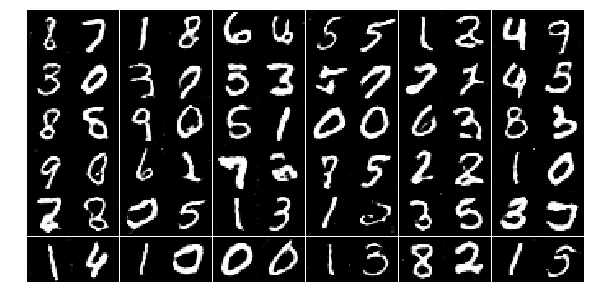

Epoch 10/30... Discriminator Loss: 0.9075... Generator Loss: 0.7751
Epoch 10/30... Discriminator Loss: 1.1363... Generator Loss: 0.5390
Epoch 10/30... Discriminator Loss: 0.6508... Generator Loss: 1.2994
Epoch 10/30... Discriminator Loss: 0.7644... Generator Loss: 1.0749
Epoch 10/30... Discriminator Loss: 1.2498... Generator Loss: 0.5045
Epoch 10/30... Discriminator Loss: 0.7731... Generator Loss: 0.8725
Epoch 10/30... Discriminator Loss: 0.6421... Generator Loss: 1.0598
Epoch 10/30... Discriminator Loss: 0.7498... Generator Loss: 1.3222
Epoch 10/30... Discriminator Loss: 0.7185... Generator Loss: 1.5795
Epoch 10/30... Discriminator Loss: 0.8134... Generator Loss: 0.8024


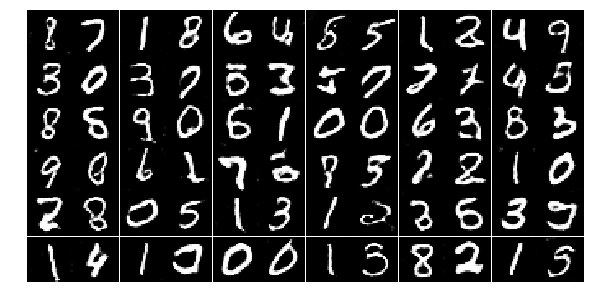

Epoch 10/30... Discriminator Loss: 0.9382... Generator Loss: 0.7270
Epoch 10/30... Discriminator Loss: 1.1757... Generator Loss: 0.5939
Epoch 10/30... Discriminator Loss: 0.6927... Generator Loss: 1.9177
Epoch 10/30... Discriminator Loss: 0.6814... Generator Loss: 1.3727
Epoch 10/30... Discriminator Loss: 0.7734... Generator Loss: 1.4536
Epoch 10/30... Discriminator Loss: 0.9059... Generator Loss: 0.8202
Epoch 10/30... Discriminator Loss: 0.6949... Generator Loss: 1.0341
Epoch 10/30... Discriminator Loss: 0.4422... Generator Loss: 1.7135
Epoch 10/30... Discriminator Loss: 0.9593... Generator Loss: 0.7193
Epoch 11/30... Discriminator Loss: 0.7798... Generator Loss: 0.9702


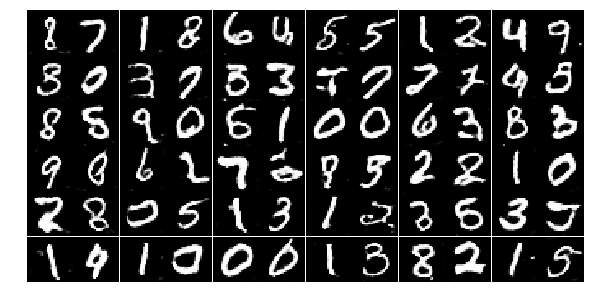

Epoch 11/30... Discriminator Loss: 0.6976... Generator Loss: 1.2172
Epoch 11/30... Discriminator Loss: 0.8269... Generator Loss: 0.8047
Epoch 11/30... Discriminator Loss: 0.4588... Generator Loss: 1.4008
Epoch 11/30... Discriminator Loss: 0.7163... Generator Loss: 1.0688
Epoch 11/30... Discriminator Loss: 1.2376... Generator Loss: 0.4982
Epoch 11/30... Discriminator Loss: 0.8333... Generator Loss: 0.8092
Epoch 11/30... Discriminator Loss: 0.6857... Generator Loss: 0.9969
Epoch 11/30... Discriminator Loss: 1.1075... Generator Loss: 0.6075
Epoch 11/30... Discriminator Loss: 0.8259... Generator Loss: 0.9845
Epoch 11/30... Discriminator Loss: 1.4641... Generator Loss: 0.3945


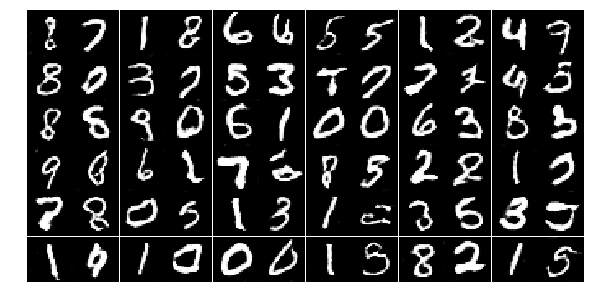

Epoch 11/30... Discriminator Loss: 0.7256... Generator Loss: 1.9669
Epoch 11/30... Discriminator Loss: 0.6782... Generator Loss: 1.2313
Epoch 11/30... Discriminator Loss: 0.9392... Generator Loss: 2.5196
Epoch 11/30... Discriminator Loss: 0.5675... Generator Loss: 2.0408
Epoch 11/30... Discriminator Loss: 1.6409... Generator Loss: 0.3554
Epoch 11/30... Discriminator Loss: 0.6819... Generator Loss: 1.2453
Epoch 11/30... Discriminator Loss: 0.6534... Generator Loss: 1.3048
Epoch 11/30... Discriminator Loss: 1.0067... Generator Loss: 0.6968
Epoch 11/30... Discriminator Loss: 0.5701... Generator Loss: 1.2296
Epoch 11/30... Discriminator Loss: 0.8041... Generator Loss: 0.8409


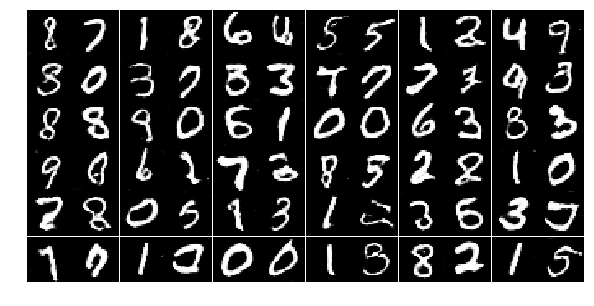

Epoch 11/30... Discriminator Loss: 0.7093... Generator Loss: 2.0711
Epoch 11/30... Discriminator Loss: 0.7378... Generator Loss: 1.1146
Epoch 11/30... Discriminator Loss: 0.5380... Generator Loss: 1.3320
Epoch 11/30... Discriminator Loss: 1.2823... Generator Loss: 0.4903
Epoch 11/30... Discriminator Loss: 0.5349... Generator Loss: 1.3973
Epoch 11/30... Discriminator Loss: 0.6450... Generator Loss: 1.1100
Epoch 11/30... Discriminator Loss: 0.5039... Generator Loss: 1.5170
Epoch 11/30... Discriminator Loss: 0.8341... Generator Loss: 0.7682
Epoch 11/30... Discriminator Loss: 0.8676... Generator Loss: 0.8389
Epoch 11/30... Discriminator Loss: 0.6846... Generator Loss: 2.2609


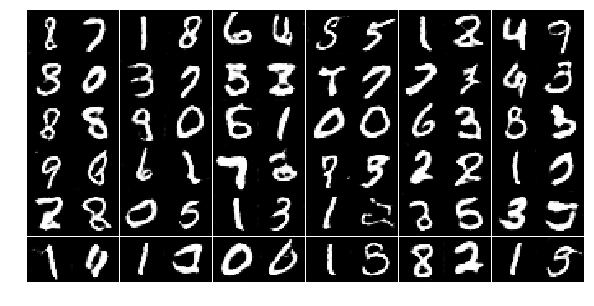

Epoch 11/30... Discriminator Loss: 0.9437... Generator Loss: 0.7645
Epoch 11/30... Discriminator Loss: 0.6019... Generator Loss: 1.5740
Epoch 11/30... Discriminator Loss: 0.5792... Generator Loss: 1.2262
Epoch 11/30... Discriminator Loss: 0.7177... Generator Loss: 0.9108
Epoch 11/30... Discriminator Loss: 1.1026... Generator Loss: 0.6330
Epoch 11/30... Discriminator Loss: 0.6036... Generator Loss: 2.1812
Epoch 11/30... Discriminator Loss: 0.6774... Generator Loss: 1.0522
Epoch 11/30... Discriminator Loss: 0.5030... Generator Loss: 2.4297
Epoch 11/30... Discriminator Loss: 1.0498... Generator Loss: 0.6143
Epoch 11/30... Discriminator Loss: 0.7404... Generator Loss: 0.9147


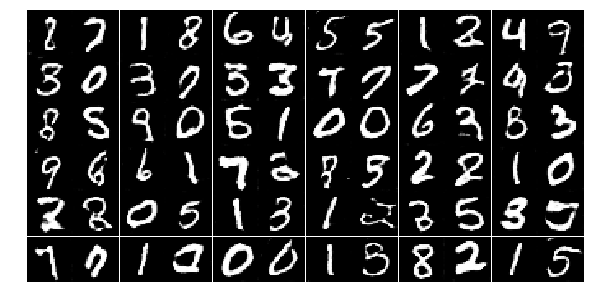

Epoch 11/30... Discriminator Loss: 0.4965... Generator Loss: 1.6144
Epoch 12/30... Discriminator Loss: 0.6875... Generator Loss: 1.1990
Epoch 12/30... Discriminator Loss: 2.0013... Generator Loss: 0.2264
Epoch 12/30... Discriminator Loss: 0.6486... Generator Loss: 2.2382
Epoch 12/30... Discriminator Loss: 0.7967... Generator Loss: 0.8944
Epoch 12/30... Discriminator Loss: 0.5926... Generator Loss: 1.4959
Epoch 12/30... Discriminator Loss: 1.4388... Generator Loss: 0.3922
Epoch 12/30... Discriminator Loss: 0.5305... Generator Loss: 1.3828
Epoch 12/30... Discriminator Loss: 0.8489... Generator Loss: 0.7931
Epoch 12/30... Discriminator Loss: 0.8826... Generator Loss: 0.8348


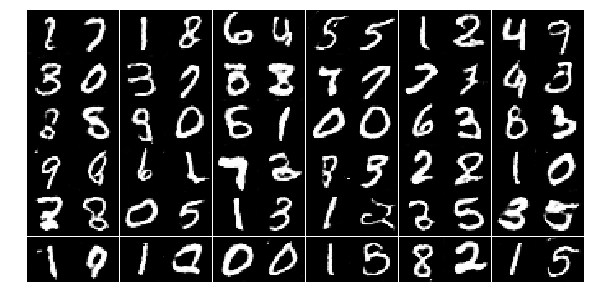

Epoch 12/30... Discriminator Loss: 0.7343... Generator Loss: 1.0337
Epoch 12/30... Discriminator Loss: 0.9863... Generator Loss: 0.8119
Epoch 12/30... Discriminator Loss: 0.6892... Generator Loss: 1.9260
Epoch 12/30... Discriminator Loss: 1.0308... Generator Loss: 0.6236
Epoch 12/30... Discriminator Loss: 1.0545... Generator Loss: 0.5804
Epoch 12/30... Discriminator Loss: 0.5341... Generator Loss: 1.2851
Epoch 12/30... Discriminator Loss: 1.0098... Generator Loss: 0.6581
Epoch 12/30... Discriminator Loss: 1.0055... Generator Loss: 0.6311
Epoch 12/30... Discriminator Loss: 1.0455... Generator Loss: 0.6667
Epoch 12/30... Discriminator Loss: 0.6582... Generator Loss: 1.1446


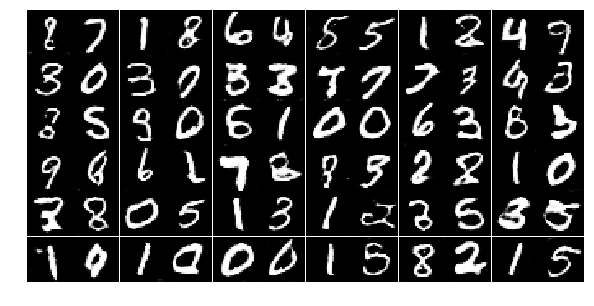

Epoch 12/30... Discriminator Loss: 0.8300... Generator Loss: 0.7827
Epoch 12/30... Discriminator Loss: 0.5444... Generator Loss: 1.8260
Epoch 12/30... Discriminator Loss: 0.8085... Generator Loss: 1.4404
Epoch 12/30... Discriminator Loss: 1.0242... Generator Loss: 0.8874
Epoch 12/30... Discriminator Loss: 0.6614... Generator Loss: 1.2696
Epoch 12/30... Discriminator Loss: 0.7409... Generator Loss: 1.0952
Epoch 12/30... Discriminator Loss: 0.5114... Generator Loss: 1.6236
Epoch 12/30... Discriminator Loss: 0.8109... Generator Loss: 0.8753
Epoch 12/30... Discriminator Loss: 0.5843... Generator Loss: 1.3849
Epoch 12/30... Discriminator Loss: 1.0631... Generator Loss: 0.5893


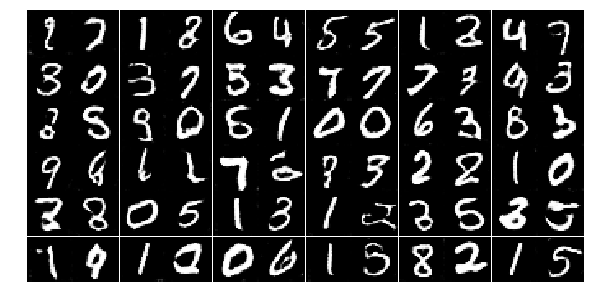

Epoch 12/30... Discriminator Loss: 0.6096... Generator Loss: 1.5485
Epoch 12/30... Discriminator Loss: 0.6611... Generator Loss: 1.1635
Epoch 12/30... Discriminator Loss: 1.1201... Generator Loss: 0.6212
Epoch 12/30... Discriminator Loss: 0.8055... Generator Loss: 0.9559
Epoch 12/30... Discriminator Loss: 0.6524... Generator Loss: 1.0721
Epoch 12/30... Discriminator Loss: 0.5243... Generator Loss: 1.7933
Epoch 12/30... Discriminator Loss: 0.7998... Generator Loss: 0.9005
Epoch 12/30... Discriminator Loss: 0.7069... Generator Loss: 0.9810
Epoch 12/30... Discriminator Loss: 0.7954... Generator Loss: 0.8627
Epoch 12/30... Discriminator Loss: 1.0370... Generator Loss: 0.6388


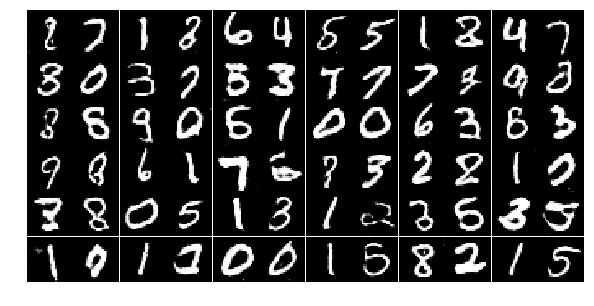

Epoch 12/30... Discriminator Loss: 0.6259... Generator Loss: 1.0824
Epoch 12/30... Discriminator Loss: 0.7353... Generator Loss: 1.0248
Epoch 12/30... Discriminator Loss: 0.9085... Generator Loss: 0.8155
Epoch 12/30... Discriminator Loss: 0.7881... Generator Loss: 2.5863
Epoch 13/30... Discriminator Loss: 1.0294... Generator Loss: 0.7462
Epoch 13/30... Discriminator Loss: 0.6726... Generator Loss: 1.1026
Epoch 13/30... Discriminator Loss: 0.4537... Generator Loss: 1.8502
Epoch 13/30... Discriminator Loss: 0.6299... Generator Loss: 1.0857
Epoch 13/30... Discriminator Loss: 0.7314... Generator Loss: 0.9566
Epoch 13/30... Discriminator Loss: 1.0266... Generator Loss: 0.6614


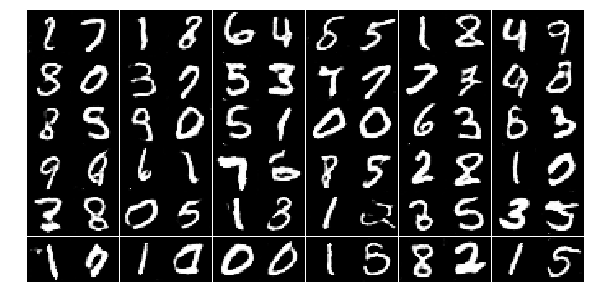

Epoch 13/30... Discriminator Loss: 0.6860... Generator Loss: 1.0875
Epoch 13/30... Discriminator Loss: 0.6996... Generator Loss: 0.9958
Epoch 13/30... Discriminator Loss: 0.6400... Generator Loss: 1.1867
Epoch 13/30... Discriminator Loss: 0.4162... Generator Loss: 1.9040
Epoch 13/30... Discriminator Loss: 0.5366... Generator Loss: 1.4036
Epoch 13/30... Discriminator Loss: 0.6408... Generator Loss: 1.2148
Epoch 13/30... Discriminator Loss: 0.6697... Generator Loss: 2.5455
Epoch 13/30... Discriminator Loss: 0.6731... Generator Loss: 2.3654
Epoch 13/30... Discriminator Loss: 0.9606... Generator Loss: 0.7559
Epoch 13/30... Discriminator Loss: 0.7120... Generator Loss: 1.4829


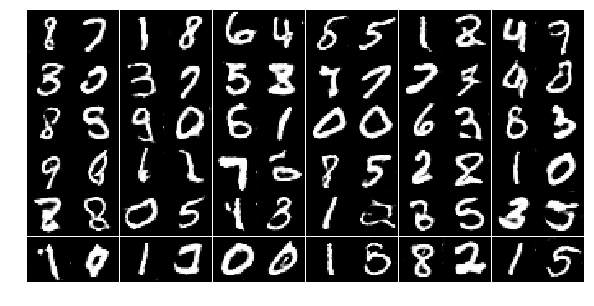

Epoch 13/30... Discriminator Loss: 1.0197... Generator Loss: 0.6459
Epoch 13/30... Discriminator Loss: 0.5807... Generator Loss: 1.1729
Epoch 13/30... Discriminator Loss: 0.7657... Generator Loss: 1.0150
Epoch 13/30... Discriminator Loss: 0.6716... Generator Loss: 1.0214
Epoch 13/30... Discriminator Loss: 1.1152... Generator Loss: 0.6049
Epoch 13/30... Discriminator Loss: 0.7619... Generator Loss: 0.9474
Epoch 13/30... Discriminator Loss: 0.4067... Generator Loss: 2.1513
Epoch 13/30... Discriminator Loss: 0.5903... Generator Loss: 1.2121
Epoch 13/30... Discriminator Loss: 0.8778... Generator Loss: 0.8052
Epoch 13/30... Discriminator Loss: 0.3962... Generator Loss: 2.2274


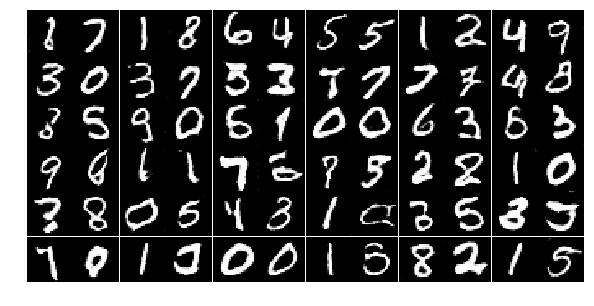

Epoch 13/30... Discriminator Loss: 0.5767... Generator Loss: 1.6382
Epoch 13/30... Discriminator Loss: 1.1982... Generator Loss: 0.6329
Epoch 13/30... Discriminator Loss: 0.5959... Generator Loss: 1.4063
Epoch 13/30... Discriminator Loss: 0.4178... Generator Loss: 1.9830
Epoch 13/30... Discriminator Loss: 1.3721... Generator Loss: 0.4382
Epoch 13/30... Discriminator Loss: 0.6101... Generator Loss: 1.0621
Epoch 13/30... Discriminator Loss: 0.5174... Generator Loss: 2.1676
Epoch 13/30... Discriminator Loss: 0.7470... Generator Loss: 0.9377
Epoch 13/30... Discriminator Loss: 0.5240... Generator Loss: 1.2804
Epoch 13/30... Discriminator Loss: 0.9199... Generator Loss: 0.8237


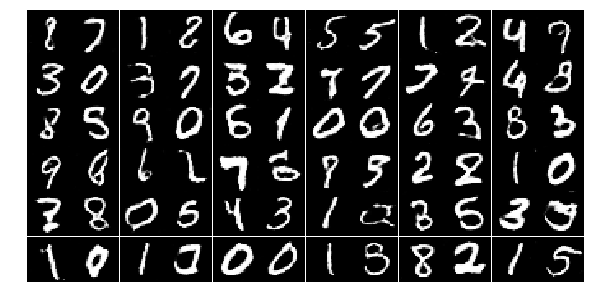

Epoch 13/30... Discriminator Loss: 1.0559... Generator Loss: 0.6363
Epoch 13/30... Discriminator Loss: 0.7209... Generator Loss: 1.0137
Epoch 13/30... Discriminator Loss: 0.6860... Generator Loss: 1.3695
Epoch 13/30... Discriminator Loss: 1.1108... Generator Loss: 2.4672
Epoch 13/30... Discriminator Loss: 0.6633... Generator Loss: 1.2704
Epoch 13/30... Discriminator Loss: 0.7171... Generator Loss: 0.9438
Epoch 13/30... Discriminator Loss: 0.5874... Generator Loss: 1.3570
Epoch 14/30... Discriminator Loss: 0.7084... Generator Loss: 0.9997
Epoch 14/30... Discriminator Loss: 0.5831... Generator Loss: 1.2567
Epoch 14/30... Discriminator Loss: 0.7584... Generator Loss: 0.8831


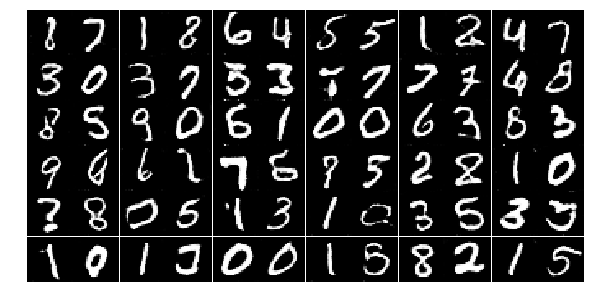

Epoch 14/30... Discriminator Loss: 0.5559... Generator Loss: 1.3425
Epoch 14/30... Discriminator Loss: 0.9339... Generator Loss: 0.7476
Epoch 14/30... Discriminator Loss: 1.5336... Generator Loss: 4.0703
Epoch 14/30... Discriminator Loss: 1.1543... Generator Loss: 0.5779
Epoch 14/30... Discriminator Loss: 0.7474... Generator Loss: 2.5167
Epoch 14/30... Discriminator Loss: 0.8737... Generator Loss: 0.8494
Epoch 14/30... Discriminator Loss: 0.5555... Generator Loss: 1.2923
Epoch 14/30... Discriminator Loss: 0.7281... Generator Loss: 1.1023
Epoch 14/30... Discriminator Loss: 0.6214... Generator Loss: 1.1915
Epoch 14/30... Discriminator Loss: 0.7257... Generator Loss: 0.9790


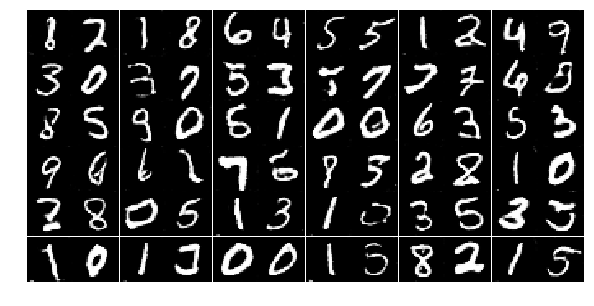

Epoch 14/30... Discriminator Loss: 0.5344... Generator Loss: 1.2845
Epoch 14/30... Discriminator Loss: 0.6585... Generator Loss: 1.1136
Epoch 14/30... Discriminator Loss: 1.0662... Generator Loss: 0.6299
Epoch 14/30... Discriminator Loss: 0.6501... Generator Loss: 2.6085
Epoch 14/30... Discriminator Loss: 0.5606... Generator Loss: 1.7293
Epoch 14/30... Discriminator Loss: 0.7832... Generator Loss: 0.9467
Epoch 14/30... Discriminator Loss: 0.8092... Generator Loss: 0.8808
Epoch 14/30... Discriminator Loss: 0.6859... Generator Loss: 0.9811
Epoch 14/30... Discriminator Loss: 1.3026... Generator Loss: 0.4868
Epoch 14/30... Discriminator Loss: 0.4259... Generator Loss: 1.9601


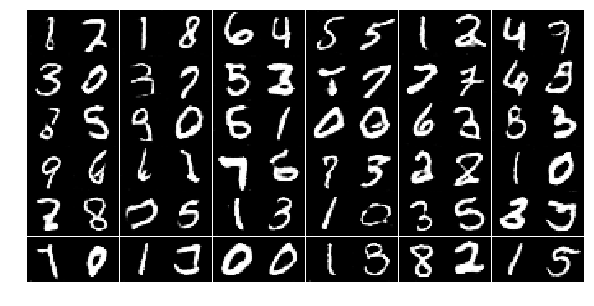

Epoch 14/30... Discriminator Loss: 0.7520... Generator Loss: 0.8814
Epoch 14/30... Discriminator Loss: 0.5949... Generator Loss: 1.3084
Epoch 14/30... Discriminator Loss: 0.6322... Generator Loss: 1.1361
Epoch 14/30... Discriminator Loss: 0.5825... Generator Loss: 2.8029
Epoch 14/30... Discriminator Loss: 0.5483... Generator Loss: 1.7234
Epoch 14/30... Discriminator Loss: 0.6973... Generator Loss: 0.9560
Epoch 14/30... Discriminator Loss: 0.8892... Generator Loss: 0.7840
Epoch 14/30... Discriminator Loss: 0.4862... Generator Loss: 1.5132
Epoch 14/30... Discriminator Loss: 0.5847... Generator Loss: 1.4495
Epoch 14/30... Discriminator Loss: 1.4893... Generator Loss: 4.4270


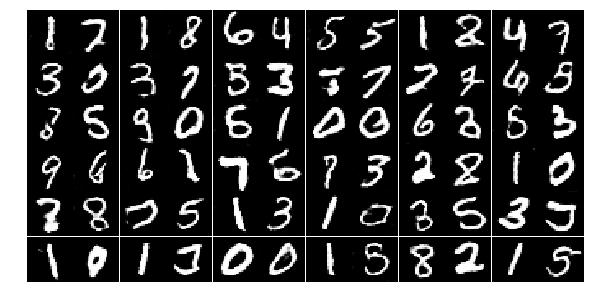

Epoch 14/30... Discriminator Loss: 0.9337... Generator Loss: 0.7449
Epoch 14/30... Discriminator Loss: 0.8412... Generator Loss: 0.8406
Epoch 14/30... Discriminator Loss: 0.5688... Generator Loss: 1.4299
Epoch 14/30... Discriminator Loss: 1.0299... Generator Loss: 0.6172
Epoch 14/30... Discriminator Loss: 0.8324... Generator Loss: 2.6596
Epoch 14/30... Discriminator Loss: 0.5907... Generator Loss: 1.2031
Epoch 14/30... Discriminator Loss: 0.6869... Generator Loss: 1.0847
Epoch 14/30... Discriminator Loss: 0.6500... Generator Loss: 1.0893
Epoch 14/30... Discriminator Loss: 0.5838... Generator Loss: 1.2581
Epoch 14/30... Discriminator Loss: 1.1198... Generator Loss: 3.3330


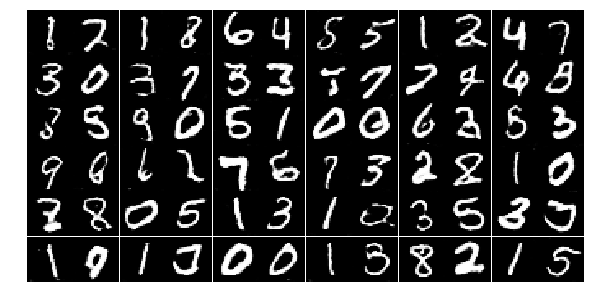

Epoch 15/30... Discriminator Loss: 0.6025... Generator Loss: 1.2242
Epoch 15/30... Discriminator Loss: 0.7361... Generator Loss: 1.0755
Epoch 15/30... Discriminator Loss: 0.7480... Generator Loss: 0.9619
Epoch 15/30... Discriminator Loss: 0.6134... Generator Loss: 2.9271
Epoch 15/30... Discriminator Loss: 0.9217... Generator Loss: 0.8105
Epoch 15/30... Discriminator Loss: 0.7288... Generator Loss: 0.9252
Epoch 15/30... Discriminator Loss: 0.4632... Generator Loss: 1.5001
Epoch 15/30... Discriminator Loss: 0.5833... Generator Loss: 1.4643
Epoch 15/30... Discriminator Loss: 0.7051... Generator Loss: 0.9730
Epoch 15/30... Discriminator Loss: 0.5962... Generator Loss: 1.6022


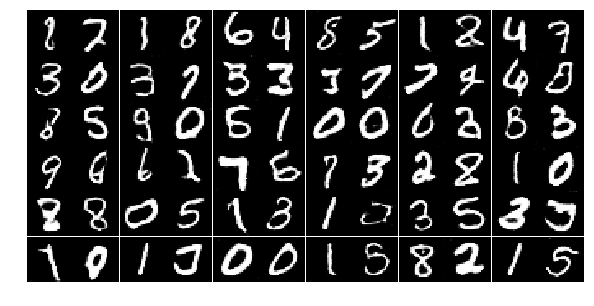

Epoch 15/30... Discriminator Loss: 1.2406... Generator Loss: 0.5084
Epoch 15/30... Discriminator Loss: 0.4134... Generator Loss: 1.7405
Epoch 15/30... Discriminator Loss: 0.6224... Generator Loss: 1.1470
Epoch 15/30... Discriminator Loss: 0.7380... Generator Loss: 1.0437
Epoch 15/30... Discriminator Loss: 0.5323... Generator Loss: 1.9556
Epoch 15/30... Discriminator Loss: 1.1974... Generator Loss: 0.5380
Epoch 15/30... Discriminator Loss: 0.7315... Generator Loss: 0.9023
Epoch 15/30... Discriminator Loss: 1.1776... Generator Loss: 0.5092
Epoch 15/30... Discriminator Loss: 0.6148... Generator Loss: 1.1279
Epoch 15/30... Discriminator Loss: 0.5362... Generator Loss: 1.3148


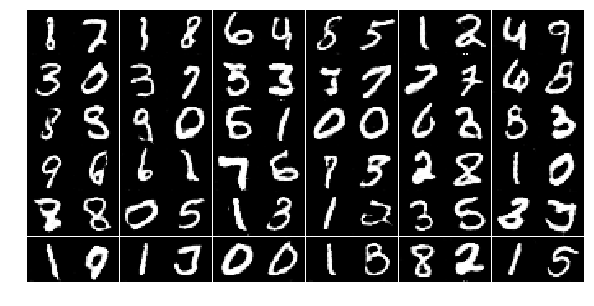

Epoch 15/30... Discriminator Loss: 0.8322... Generator Loss: 0.8135
Epoch 15/30... Discriminator Loss: 1.8338... Generator Loss: 4.3891
Epoch 15/30... Discriminator Loss: 0.6446... Generator Loss: 1.1656
Epoch 15/30... Discriminator Loss: 0.7521... Generator Loss: 0.9365
Epoch 15/30... Discriminator Loss: 0.6427... Generator Loss: 1.5819
Epoch 15/30... Discriminator Loss: 0.4895... Generator Loss: 1.4465
Epoch 15/30... Discriminator Loss: 1.7662... Generator Loss: 4.1042
Epoch 15/30... Discriminator Loss: 1.1818... Generator Loss: 0.5950
Epoch 15/30... Discriminator Loss: 0.5561... Generator Loss: 1.4717
Epoch 15/30... Discriminator Loss: 0.3834... Generator Loss: 2.0454


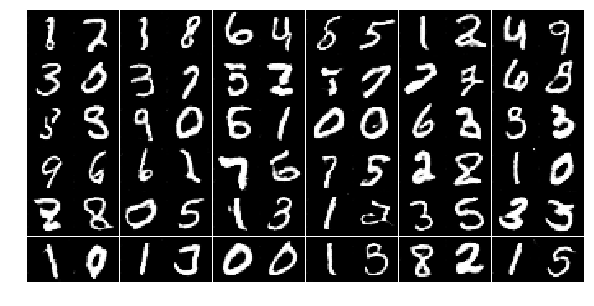

Epoch 15/30... Discriminator Loss: 0.9789... Generator Loss: 0.6672
Epoch 15/30... Discriminator Loss: 0.8614... Generator Loss: 0.8077
Epoch 15/30... Discriminator Loss: 0.5257... Generator Loss: 1.5184
Epoch 15/30... Discriminator Loss: 1.3017... Generator Loss: 0.5151
Epoch 15/30... Discriminator Loss: 0.5961... Generator Loss: 1.7569
Epoch 15/30... Discriminator Loss: 0.4554... Generator Loss: 2.0264
Epoch 15/30... Discriminator Loss: 0.6541... Generator Loss: 1.1270
Epoch 15/30... Discriminator Loss: 0.5233... Generator Loss: 1.3753
Epoch 15/30... Discriminator Loss: 0.9264... Generator Loss: 0.7425
Epoch 15/30... Discriminator Loss: 0.3817... Generator Loss: 1.6845


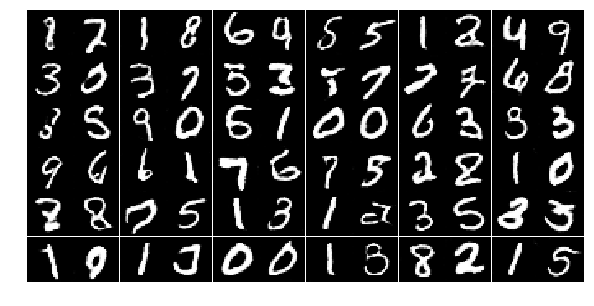

Epoch 15/30... Discriminator Loss: 0.5559... Generator Loss: 1.4234
Epoch 15/30... Discriminator Loss: 1.1671... Generator Loss: 0.6313
Epoch 15/30... Discriminator Loss: 0.7046... Generator Loss: 1.0424
Epoch 16/30... Discriminator Loss: 0.6462... Generator Loss: 1.2178
Epoch 16/30... Discriminator Loss: 0.5965... Generator Loss: 1.1826
Epoch 16/30... Discriminator Loss: 0.7102... Generator Loss: 0.9555
Epoch 16/30... Discriminator Loss: 0.6490... Generator Loss: 1.0360
Epoch 16/30... Discriminator Loss: 1.0776... Generator Loss: 0.6337
Epoch 16/30... Discriminator Loss: 0.5883... Generator Loss: 1.1901
Epoch 16/30... Discriminator Loss: 0.4241... Generator Loss: 1.7795


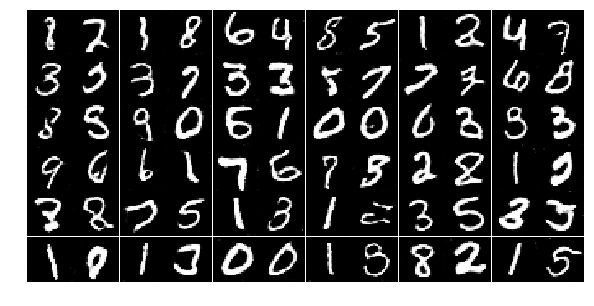

Epoch 16/30... Discriminator Loss: 0.7960... Generator Loss: 0.8677
Epoch 16/30... Discriminator Loss: 0.6138... Generator Loss: 2.2478
Epoch 16/30... Discriminator Loss: 1.0740... Generator Loss: 0.6010
Epoch 16/30... Discriminator Loss: 0.4954... Generator Loss: 1.4810
Epoch 16/30... Discriminator Loss: 0.8598... Generator Loss: 0.7697
Epoch 16/30... Discriminator Loss: 0.4052... Generator Loss: 2.0153
Epoch 16/30... Discriminator Loss: 1.8397... Generator Loss: 5.2909
Epoch 16/30... Discriminator Loss: 0.6507... Generator Loss: 1.7026
Epoch 16/30... Discriminator Loss: 1.3288... Generator Loss: 0.5261
Epoch 16/30... Discriminator Loss: 0.7593... Generator Loss: 1.0429


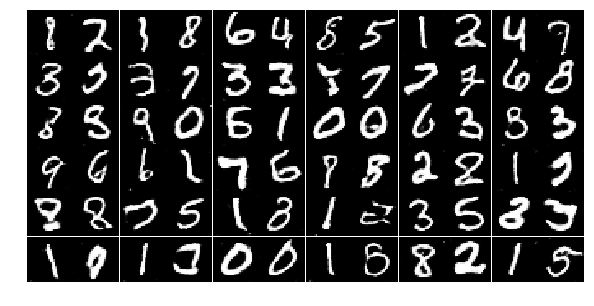

Epoch 16/30... Discriminator Loss: 0.4446... Generator Loss: 1.8265
Epoch 16/30... Discriminator Loss: 0.8217... Generator Loss: 0.9642
Epoch 16/30... Discriminator Loss: 0.5394... Generator Loss: 1.3413
Epoch 16/30... Discriminator Loss: 0.8215... Generator Loss: 0.8493
Epoch 16/30... Discriminator Loss: 1.1313... Generator Loss: 0.5630
Epoch 16/30... Discriminator Loss: 0.9939... Generator Loss: 0.6933
Epoch 16/30... Discriminator Loss: 0.7659... Generator Loss: 0.9712
Epoch 16/30... Discriminator Loss: 0.5728... Generator Loss: 1.3922
Epoch 16/30... Discriminator Loss: 0.7125... Generator Loss: 0.9978
Epoch 16/30... Discriminator Loss: 0.6322... Generator Loss: 1.1952


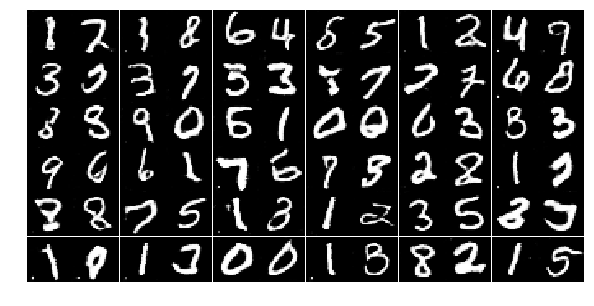

Epoch 16/30... Discriminator Loss: 0.4775... Generator Loss: 1.7847
Epoch 16/30... Discriminator Loss: 1.0220... Generator Loss: 0.6728
Epoch 16/30... Discriminator Loss: 0.5827... Generator Loss: 2.3604
Epoch 16/30... Discriminator Loss: 0.5724... Generator Loss: 1.5646
Epoch 16/30... Discriminator Loss: 0.6200... Generator Loss: 1.4269
Epoch 16/30... Discriminator Loss: 0.6088... Generator Loss: 1.6359
Epoch 16/30... Discriminator Loss: 1.2043... Generator Loss: 0.5424
Epoch 16/30... Discriminator Loss: 1.0165... Generator Loss: 0.6967
Epoch 16/30... Discriminator Loss: 0.5899... Generator Loss: 1.1080
Epoch 16/30... Discriminator Loss: 0.8077... Generator Loss: 0.8285


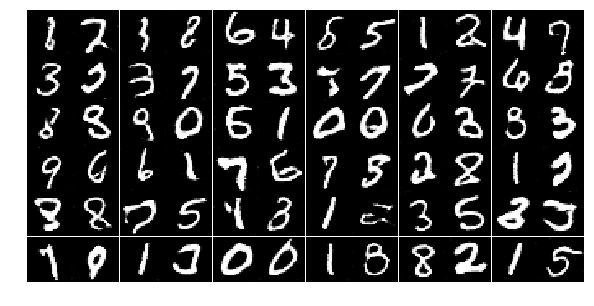

Epoch 16/30... Discriminator Loss: 0.6752... Generator Loss: 1.0214
Epoch 16/30... Discriminator Loss: 0.9687... Generator Loss: 0.7242
Epoch 16/30... Discriminator Loss: 0.8206... Generator Loss: 0.9461
Epoch 16/30... Discriminator Loss: 0.4818... Generator Loss: 1.5268
Epoch 16/30... Discriminator Loss: 0.5559... Generator Loss: 1.6286
Epoch 16/30... Discriminator Loss: 1.2944... Generator Loss: 0.5083
Epoch 17/30... Discriminator Loss: 0.5760... Generator Loss: 1.4256
Epoch 17/30... Discriminator Loss: 0.5174... Generator Loss: 1.8098
Epoch 17/30... Discriminator Loss: 0.5223... Generator Loss: 1.9166
Epoch 17/30... Discriminator Loss: 0.8528... Generator Loss: 0.8112


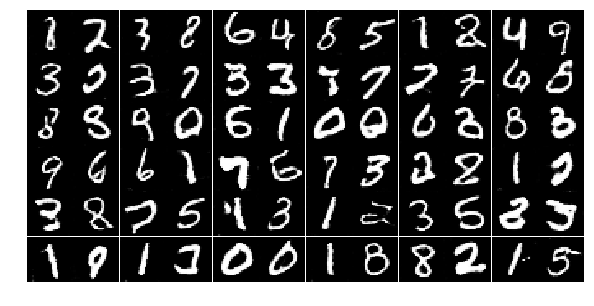

Epoch 17/30... Discriminator Loss: 0.4016... Generator Loss: 1.7697
Epoch 17/30... Discriminator Loss: 0.8707... Generator Loss: 0.7420
Epoch 17/30... Discriminator Loss: 0.4139... Generator Loss: 1.9763
Epoch 17/30... Discriminator Loss: 0.7597... Generator Loss: 0.9297
Epoch 17/30... Discriminator Loss: 0.9926... Generator Loss: 0.6787
Epoch 17/30... Discriminator Loss: 0.7801... Generator Loss: 0.9130
Epoch 17/30... Discriminator Loss: 2.3001... Generator Loss: 4.3021
Epoch 17/30... Discriminator Loss: 0.6947... Generator Loss: 1.2430
Epoch 17/30... Discriminator Loss: 0.6254... Generator Loss: 1.4755
Epoch 17/30... Discriminator Loss: 0.5995... Generator Loss: 1.2052


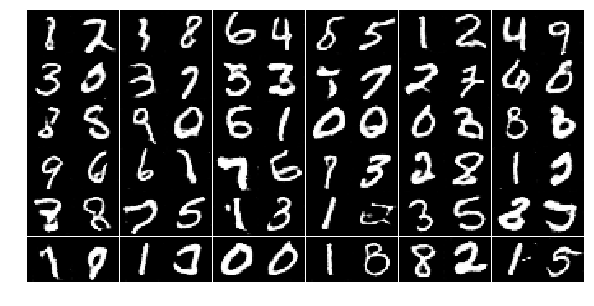

Epoch 17/30... Discriminator Loss: 0.6173... Generator Loss: 1.5948
Epoch 17/30... Discriminator Loss: 0.4139... Generator Loss: 1.6187
Epoch 17/30... Discriminator Loss: 0.5486... Generator Loss: 1.5097
Epoch 17/30... Discriminator Loss: 0.6531... Generator Loss: 1.0938
Epoch 17/30... Discriminator Loss: 0.6747... Generator Loss: 0.9917
Epoch 17/30... Discriminator Loss: 0.3758... Generator Loss: 1.8200
Epoch 17/30... Discriminator Loss: 0.5817... Generator Loss: 1.6387
Epoch 17/30... Discriminator Loss: 1.0655... Generator Loss: 0.6182
Epoch 17/30... Discriminator Loss: 0.6830... Generator Loss: 0.9708
Epoch 17/30... Discriminator Loss: 0.6637... Generator Loss: 1.0915


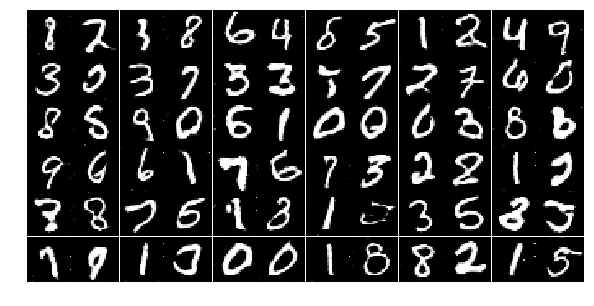

Epoch 17/30... Discriminator Loss: 0.8422... Generator Loss: 0.7836
Epoch 17/30... Discriminator Loss: 1.1269... Generator Loss: 0.5949
Epoch 17/30... Discriminator Loss: 0.6343... Generator Loss: 1.3106
Epoch 17/30... Discriminator Loss: 0.5238... Generator Loss: 1.4598
Epoch 17/30... Discriminator Loss: 0.7104... Generator Loss: 1.0114
Epoch 17/30... Discriminator Loss: 0.6926... Generator Loss: 0.9592
Epoch 17/30... Discriminator Loss: 0.7821... Generator Loss: 0.9466
Epoch 17/30... Discriminator Loss: 0.5547... Generator Loss: 1.3292
Epoch 17/30... Discriminator Loss: 0.8448... Generator Loss: 0.8077
Epoch 17/30... Discriminator Loss: 0.5966... Generator Loss: 1.2745


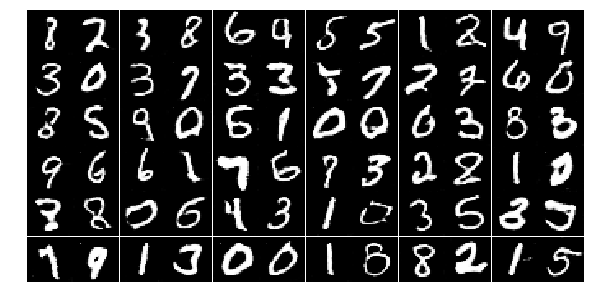

Epoch 17/30... Discriminator Loss: 0.8836... Generator Loss: 0.7684
Epoch 17/30... Discriminator Loss: 3.7043... Generator Loss: 5.9246
Epoch 17/30... Discriminator Loss: 0.5938... Generator Loss: 1.7480
Epoch 17/30... Discriminator Loss: 0.7287... Generator Loss: 2.4467
Epoch 17/30... Discriminator Loss: 0.5431... Generator Loss: 1.4154
Epoch 17/30... Discriminator Loss: 0.7961... Generator Loss: 0.8939
Epoch 17/30... Discriminator Loss: 0.8113... Generator Loss: 0.8405
Epoch 17/30... Discriminator Loss: 1.0894... Generator Loss: 0.5870
Epoch 17/30... Discriminator Loss: 1.1542... Generator Loss: 0.5800
Epoch 18/30... Discriminator Loss: 1.3828... Generator Loss: 0.4861


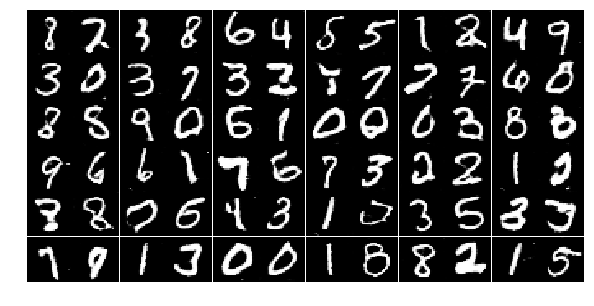

Epoch 18/30... Discriminator Loss: 0.4636... Generator Loss: 1.7366
Epoch 18/30... Discriminator Loss: 1.0135... Generator Loss: 0.6927
Epoch 18/30... Discriminator Loss: 0.4338... Generator Loss: 1.6791
Epoch 18/30... Discriminator Loss: 1.1809... Generator Loss: 0.5438
Epoch 18/30... Discriminator Loss: 1.1452... Generator Loss: 0.5740
Epoch 18/30... Discriminator Loss: 0.3614... Generator Loss: 1.9492
Epoch 18/30... Discriminator Loss: 2.7056... Generator Loss: 0.1593
Epoch 18/30... Discriminator Loss: 0.6663... Generator Loss: 1.8249
Epoch 18/30... Discriminator Loss: 0.8978... Generator Loss: 0.8854
Epoch 18/30... Discriminator Loss: 0.6049... Generator Loss: 1.2539


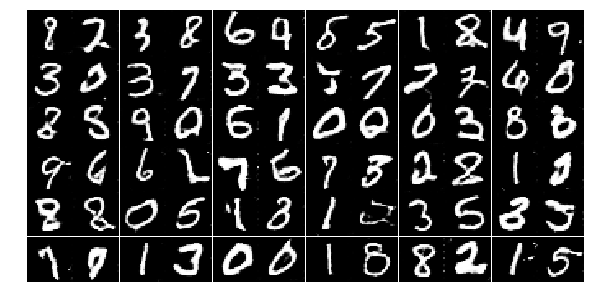

Epoch 18/30... Discriminator Loss: 0.6595... Generator Loss: 1.0352
Epoch 18/30... Discriminator Loss: 0.8259... Generator Loss: 0.8495
Epoch 18/30... Discriminator Loss: 0.4804... Generator Loss: 1.6496
Epoch 18/30... Discriminator Loss: 0.8015... Generator Loss: 0.8338
Epoch 18/30... Discriminator Loss: 0.5995... Generator Loss: 1.2313
Epoch 18/30... Discriminator Loss: 0.8890... Generator Loss: 0.8114
Epoch 18/30... Discriminator Loss: 0.9105... Generator Loss: 0.8078
Epoch 18/30... Discriminator Loss: 0.6214... Generator Loss: 1.1061
Epoch 18/30... Discriminator Loss: 0.4385... Generator Loss: 1.4527
Epoch 18/30... Discriminator Loss: 0.5963... Generator Loss: 1.1797


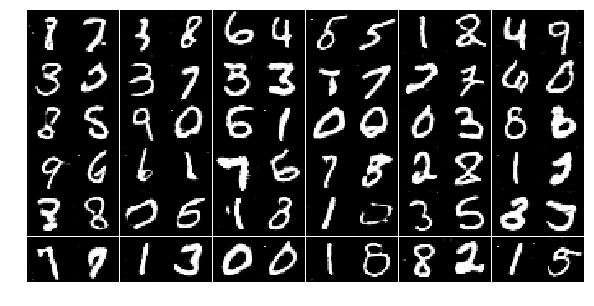

Epoch 18/30... Discriminator Loss: 0.7411... Generator Loss: 0.9029
Epoch 18/30... Discriminator Loss: 0.6287... Generator Loss: 1.1060
Epoch 18/30... Discriminator Loss: 0.5852... Generator Loss: 1.6122
Epoch 18/30... Discriminator Loss: 0.8034... Generator Loss: 1.1030
Epoch 18/30... Discriminator Loss: 1.0714... Generator Loss: 0.6712
Epoch 18/30... Discriminator Loss: 1.0034... Generator Loss: 0.6632
Epoch 18/30... Discriminator Loss: 0.6032... Generator Loss: 1.0992
Epoch 18/30... Discriminator Loss: 0.4268... Generator Loss: 1.8146
Epoch 18/30... Discriminator Loss: 0.8042... Generator Loss: 0.8476
Epoch 18/30... Discriminator Loss: 0.5539... Generator Loss: 1.3306


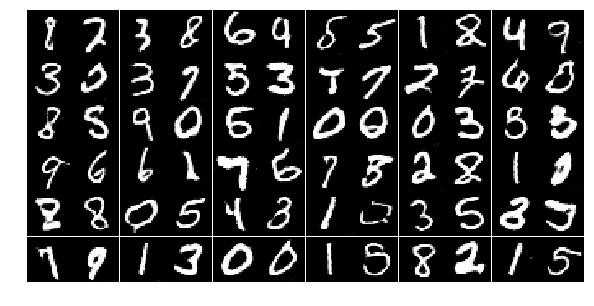

Epoch 18/30... Discriminator Loss: 1.3517... Generator Loss: 0.4319
Epoch 18/30... Discriminator Loss: 0.3115... Generator Loss: 1.9312
Epoch 18/30... Discriminator Loss: 1.9166... Generator Loss: 4.9319
Epoch 18/30... Discriminator Loss: 0.9478... Generator Loss: 3.0391
Epoch 18/30... Discriminator Loss: 0.7780... Generator Loss: 3.1333
Epoch 18/30... Discriminator Loss: 0.4268... Generator Loss: 1.6563
Epoch 18/30... Discriminator Loss: 0.7380... Generator Loss: 1.0770
Epoch 18/30... Discriminator Loss: 1.0540... Generator Loss: 0.6143
Epoch 18/30... Discriminator Loss: 0.5433... Generator Loss: 1.4646
Epoch 18/30... Discriminator Loss: 1.0643... Generator Loss: 0.6235


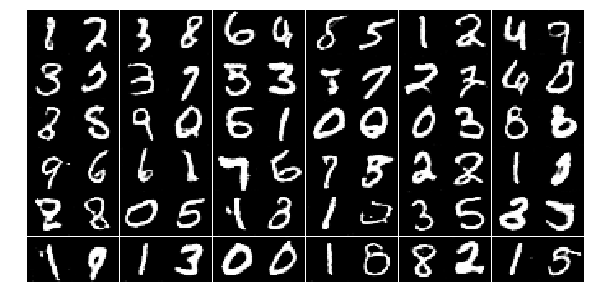

Epoch 18/30... Discriminator Loss: 1.1064... Generator Loss: 0.5628
Epoch 18/30... Discriminator Loss: 1.0391... Generator Loss: 0.6560
Epoch 19/30... Discriminator Loss: 1.3200... Generator Loss: 0.4451
Epoch 19/30... Discriminator Loss: 0.8704... Generator Loss: 0.8509
Epoch 19/30... Discriminator Loss: 0.7526... Generator Loss: 0.9350
Epoch 19/30... Discriminator Loss: 0.5243... Generator Loss: 1.3147
Epoch 19/30... Discriminator Loss: 0.9915... Generator Loss: 0.6753
Epoch 19/30... Discriminator Loss: 0.8056... Generator Loss: 0.9026
Epoch 19/30... Discriminator Loss: 0.6475... Generator Loss: 1.7163
Epoch 19/30... Discriminator Loss: 0.8292... Generator Loss: 2.7390


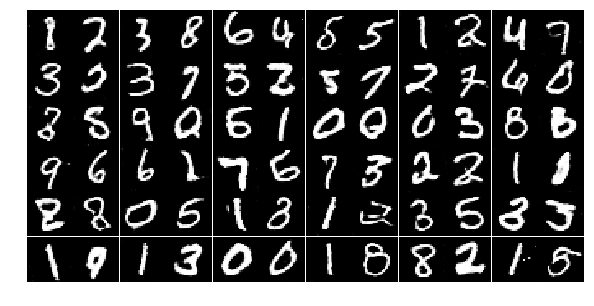

Epoch 19/30... Discriminator Loss: 1.0623... Generator Loss: 3.8725
Epoch 19/30... Discriminator Loss: 1.2055... Generator Loss: 0.5561
Epoch 19/30... Discriminator Loss: 0.4652... Generator Loss: 1.7746
Epoch 19/30... Discriminator Loss: 0.9069... Generator Loss: 0.7300
Epoch 19/30... Discriminator Loss: 1.0366... Generator Loss: 3.7049
Epoch 19/30... Discriminator Loss: 0.5793... Generator Loss: 1.2728
Epoch 19/30... Discriminator Loss: 1.0028... Generator Loss: 0.7079
Epoch 19/30... Discriminator Loss: 0.6216... Generator Loss: 1.6488
Epoch 19/30... Discriminator Loss: 0.8555... Generator Loss: 0.8301
Epoch 19/30... Discriminator Loss: 0.5911... Generator Loss: 1.2400


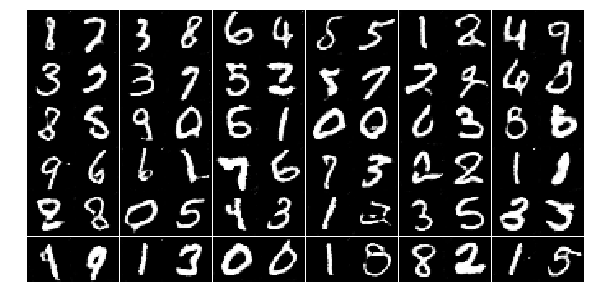

Epoch 19/30... Discriminator Loss: 0.5646... Generator Loss: 1.1702
Epoch 19/30... Discriminator Loss: 0.4325... Generator Loss: 1.4929
Epoch 19/30... Discriminator Loss: 0.7555... Generator Loss: 0.9949
Epoch 19/30... Discriminator Loss: 0.8117... Generator Loss: 0.8530
Epoch 19/30... Discriminator Loss: 0.7733... Generator Loss: 0.9242
Epoch 19/30... Discriminator Loss: 0.8616... Generator Loss: 0.8199
Epoch 19/30... Discriminator Loss: 0.9686... Generator Loss: 0.7129
Epoch 19/30... Discriminator Loss: 0.4825... Generator Loss: 1.4302
Epoch 19/30... Discriminator Loss: 0.4374... Generator Loss: 1.7112
Epoch 19/30... Discriminator Loss: 0.9449... Generator Loss: 0.7264


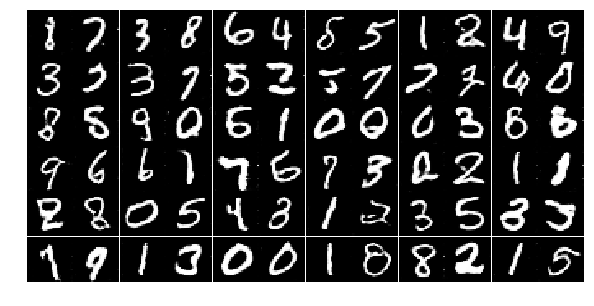

Epoch 19/30... Discriminator Loss: 1.9265... Generator Loss: 0.2430
Epoch 19/30... Discriminator Loss: 0.5057... Generator Loss: 1.9057
Epoch 19/30... Discriminator Loss: 1.0457... Generator Loss: 0.6714
Epoch 19/30... Discriminator Loss: 0.6677... Generator Loss: 1.0167
Epoch 19/30... Discriminator Loss: 0.5218... Generator Loss: 1.2942
Epoch 19/30... Discriminator Loss: 0.6063... Generator Loss: 1.1910
Epoch 19/30... Discriminator Loss: 0.6403... Generator Loss: 1.0787
Epoch 19/30... Discriminator Loss: 0.6773... Generator Loss: 1.0759
Epoch 19/30... Discriminator Loss: 0.6482... Generator Loss: 1.0096
Epoch 19/30... Discriminator Loss: 0.5025... Generator Loss: 1.5728


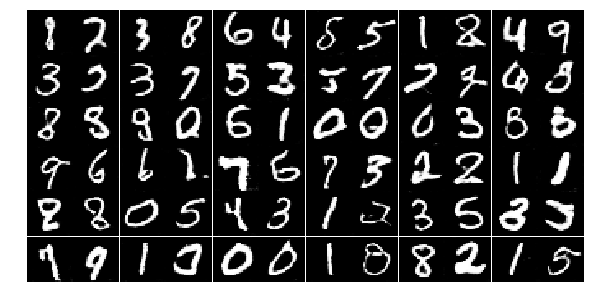

Epoch 19/30... Discriminator Loss: 0.9789... Generator Loss: 0.6445
Epoch 19/30... Discriminator Loss: 0.5790... Generator Loss: 1.1518
Epoch 19/30... Discriminator Loss: 0.5001... Generator Loss: 1.6197
Epoch 19/30... Discriminator Loss: 0.5758... Generator Loss: 1.4270
Epoch 19/30... Discriminator Loss: 1.0580... Generator Loss: 0.6175
Epoch 20/30... Discriminator Loss: 0.8342... Generator Loss: 0.8630
Epoch 20/30... Discriminator Loss: 0.8013... Generator Loss: 0.8696
Epoch 20/30... Discriminator Loss: 0.9218... Generator Loss: 0.7689
Epoch 20/30... Discriminator Loss: 1.2957... Generator Loss: 0.5428
Epoch 20/30... Discriminator Loss: 0.6069... Generator Loss: 1.0680


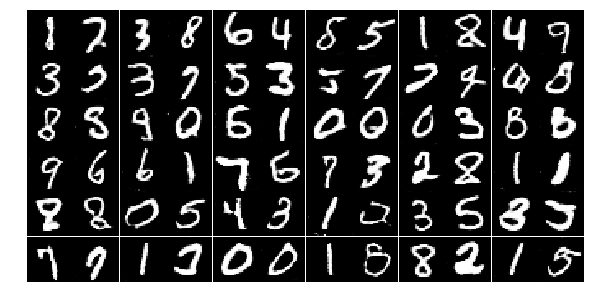

Epoch 20/30... Discriminator Loss: 0.8700... Generator Loss: 0.7566
Epoch 20/30... Discriminator Loss: 0.4583... Generator Loss: 1.4641
Epoch 20/30... Discriminator Loss: 0.9246... Generator Loss: 3.1237
Epoch 20/30... Discriminator Loss: 0.4902... Generator Loss: 1.7556
Epoch 20/30... Discriminator Loss: 2.1526... Generator Loss: 0.2678
Epoch 20/30... Discriminator Loss: 0.8249... Generator Loss: 0.8414
Epoch 20/30... Discriminator Loss: 0.4802... Generator Loss: 1.5634
Epoch 20/30... Discriminator Loss: 0.8921... Generator Loss: 0.9086
Epoch 20/30... Discriminator Loss: 0.5237... Generator Loss: 1.4497
Epoch 20/30... Discriminator Loss: 0.5305... Generator Loss: 1.5280


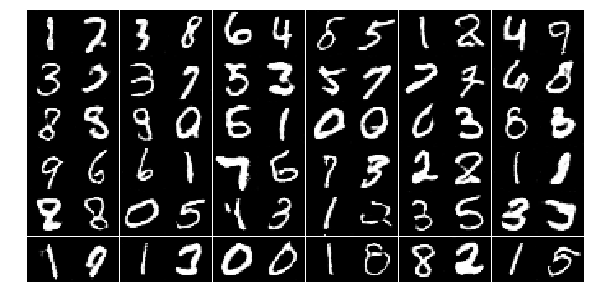

Epoch 20/30... Discriminator Loss: 1.0741... Generator Loss: 0.6139
Epoch 20/30... Discriminator Loss: 0.6794... Generator Loss: 1.2620
Epoch 20/30... Discriminator Loss: 0.6884... Generator Loss: 1.0418
Epoch 20/30... Discriminator Loss: 0.5671... Generator Loss: 1.1956
Epoch 20/30... Discriminator Loss: 1.1805... Generator Loss: 0.5461
Epoch 20/30... Discriminator Loss: 1.5614... Generator Loss: 4.5427
Epoch 20/30... Discriminator Loss: 0.5533... Generator Loss: 1.7825
Epoch 20/30... Discriminator Loss: 0.4634... Generator Loss: 1.6804
Epoch 20/30... Discriminator Loss: 0.5528... Generator Loss: 1.3612
Epoch 20/30... Discriminator Loss: 0.5983... Generator Loss: 2.2868


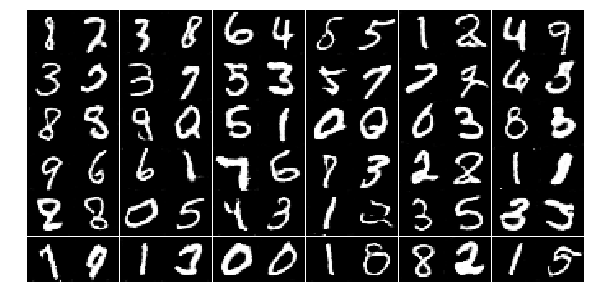

Epoch 20/30... Discriminator Loss: 0.4363... Generator Loss: 2.7024
Epoch 20/30... Discriminator Loss: 0.5606... Generator Loss: 1.8131
Epoch 20/30... Discriminator Loss: 0.6587... Generator Loss: 1.1149
Epoch 20/30... Discriminator Loss: 0.6128... Generator Loss: 1.4976
Epoch 20/30... Discriminator Loss: 0.5370... Generator Loss: 1.2268
Epoch 20/30... Discriminator Loss: 0.7757... Generator Loss: 0.8948
Epoch 20/30... Discriminator Loss: 1.0364... Generator Loss: 0.6622
Epoch 20/30... Discriminator Loss: 0.7910... Generator Loss: 0.8254
Epoch 20/30... Discriminator Loss: 0.8189... Generator Loss: 0.8188
Epoch 20/30... Discriminator Loss: 0.6470... Generator Loss: 1.0509


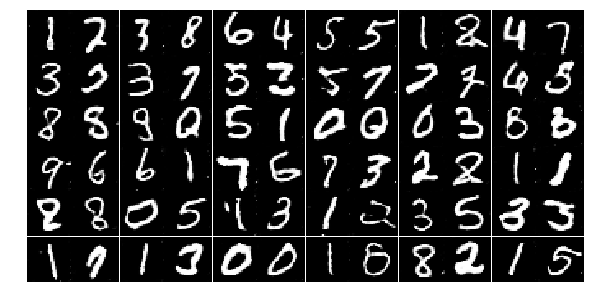

Epoch 20/30... Discriminator Loss: 0.7027... Generator Loss: 0.9664
Epoch 20/30... Discriminator Loss: 2.8183... Generator Loss: 6.0104
Epoch 20/30... Discriminator Loss: 0.7869... Generator Loss: 0.9850
Epoch 20/30... Discriminator Loss: 0.5125... Generator Loss: 1.9625
Epoch 20/30... Discriminator Loss: 0.9669... Generator Loss: 0.6856
Epoch 20/30... Discriminator Loss: 0.7157... Generator Loss: 1.2733
Epoch 20/30... Discriminator Loss: 1.1874... Generator Loss: 0.6180
Epoch 20/30... Discriminator Loss: 0.6941... Generator Loss: 0.9989
Epoch 21/30... Discriminator Loss: 0.7581... Generator Loss: 2.3289
Epoch 21/30... Discriminator Loss: 0.6910... Generator Loss: 1.0800


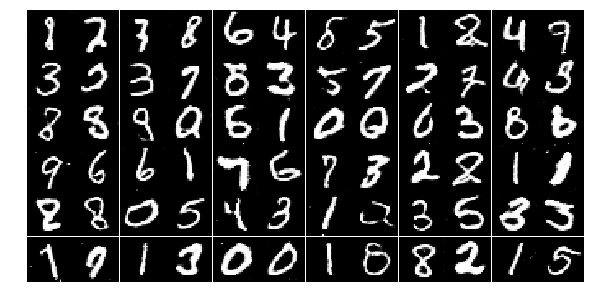

Epoch 21/30... Discriminator Loss: 0.6859... Generator Loss: 3.3513
Epoch 21/30... Discriminator Loss: 0.5810... Generator Loss: 2.1143
Epoch 21/30... Discriminator Loss: 0.7285... Generator Loss: 1.0851
Epoch 21/30... Discriminator Loss: 0.5582... Generator Loss: 1.6143
Epoch 21/30... Discriminator Loss: 0.7566... Generator Loss: 1.0063
Epoch 21/30... Discriminator Loss: 0.8427... Generator Loss: 0.8815
Epoch 21/30... Discriminator Loss: 0.7859... Generator Loss: 0.8543
Epoch 21/30... Discriminator Loss: 1.2813... Generator Loss: 0.4730
Epoch 21/30... Discriminator Loss: 0.4096... Generator Loss: 1.7169
Epoch 21/30... Discriminator Loss: 0.5150... Generator Loss: 1.2603


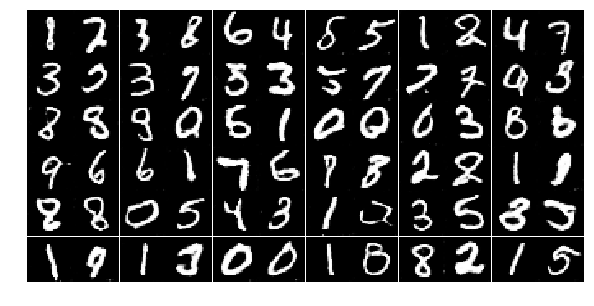

Epoch 21/30... Discriminator Loss: 1.4237... Generator Loss: 0.4336
Epoch 21/30... Discriminator Loss: 0.6380... Generator Loss: 1.2295
Epoch 21/30... Discriminator Loss: 0.6550... Generator Loss: 2.8352
Epoch 21/30... Discriminator Loss: 0.4883... Generator Loss: 2.2824
Epoch 21/30... Discriminator Loss: 0.4813... Generator Loss: 1.5943
Epoch 21/30... Discriminator Loss: 0.4569... Generator Loss: 1.4629
Epoch 21/30... Discriminator Loss: 0.6326... Generator Loss: 1.2381
Epoch 21/30... Discriminator Loss: 0.6892... Generator Loss: 1.0339
Epoch 21/30... Discriminator Loss: 0.5362... Generator Loss: 1.3562
Epoch 21/30... Discriminator Loss: 0.6913... Generator Loss: 0.9629


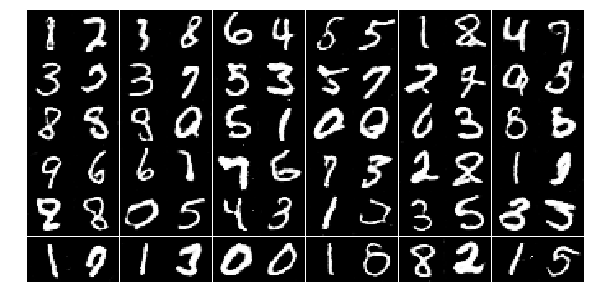

Epoch 21/30... Discriminator Loss: 0.4561... Generator Loss: 1.4367
Epoch 21/30... Discriminator Loss: 1.0469... Generator Loss: 0.6345
Epoch 21/30... Discriminator Loss: 0.5712... Generator Loss: 1.2716
Epoch 21/30... Discriminator Loss: 0.5728... Generator Loss: 1.2419
Epoch 21/30... Discriminator Loss: 0.4448... Generator Loss: 1.5428
Epoch 21/30... Discriminator Loss: 0.5508... Generator Loss: 2.0768
Epoch 21/30... Discriminator Loss: 0.5998... Generator Loss: 1.3543
Epoch 21/30... Discriminator Loss: 0.3739... Generator Loss: 2.0684
Epoch 21/30... Discriminator Loss: 0.4337... Generator Loss: 1.7871
Epoch 21/30... Discriminator Loss: 0.5275... Generator Loss: 1.3336


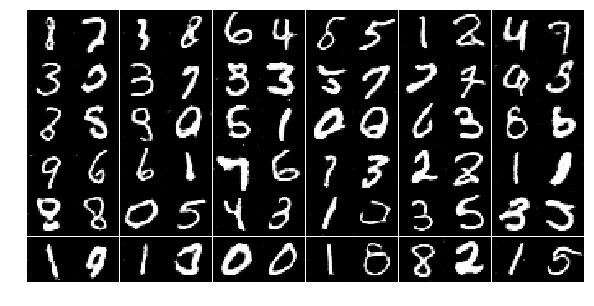

Epoch 21/30... Discriminator Loss: 0.5125... Generator Loss: 1.2845
Epoch 21/30... Discriminator Loss: 0.5616... Generator Loss: 1.1823
Epoch 21/30... Discriminator Loss: 0.6711... Generator Loss: 1.5827
Epoch 21/30... Discriminator Loss: 0.5749... Generator Loss: 2.0510
Epoch 21/30... Discriminator Loss: 0.5223... Generator Loss: 1.4264
Epoch 21/30... Discriminator Loss: 0.5427... Generator Loss: 1.2739
Epoch 21/30... Discriminator Loss: 0.7984... Generator Loss: 0.8540
Epoch 21/30... Discriminator Loss: 0.9728... Generator Loss: 2.6798
Epoch 21/30... Discriminator Loss: 0.6899... Generator Loss: 1.0106
Epoch 21/30... Discriminator Loss: 1.4219... Generator Loss: 0.4627


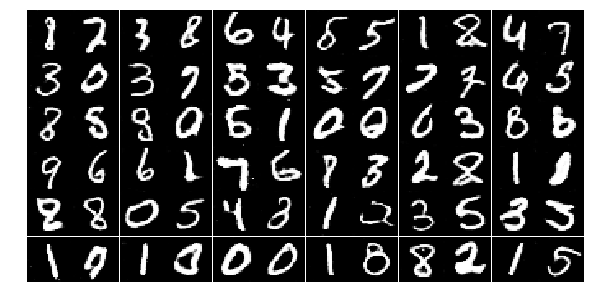

Epoch 22/30... Discriminator Loss: 0.6602... Generator Loss: 1.2330
Epoch 22/30... Discriminator Loss: 0.4400... Generator Loss: 1.6642
Epoch 22/30... Discriminator Loss: 0.6333... Generator Loss: 1.1405
Epoch 22/30... Discriminator Loss: 1.1303... Generator Loss: 0.5705
Epoch 22/30... Discriminator Loss: 0.9832... Generator Loss: 0.7756
Epoch 22/30... Discriminator Loss: 1.1332... Generator Loss: 0.6168
Epoch 22/30... Discriminator Loss: 0.4292... Generator Loss: 1.4195
Epoch 22/30... Discriminator Loss: 0.8404... Generator Loss: 0.8399
Epoch 22/30... Discriminator Loss: 0.5473... Generator Loss: 1.1997
Epoch 22/30... Discriminator Loss: 0.7295... Generator Loss: 1.0216


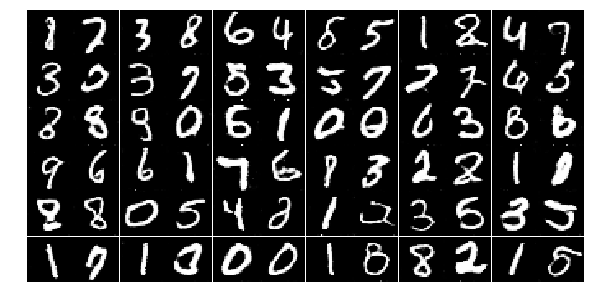

Epoch 22/30... Discriminator Loss: 0.4813... Generator Loss: 1.5262
Epoch 22/30... Discriminator Loss: 0.5936... Generator Loss: 1.1577
Epoch 22/30... Discriminator Loss: 0.5291... Generator Loss: 2.3330
Epoch 22/30... Discriminator Loss: 0.5622... Generator Loss: 1.3320
Epoch 22/30... Discriminator Loss: 0.8401... Generator Loss: 0.8009
Epoch 22/30... Discriminator Loss: 0.6548... Generator Loss: 1.0239
Epoch 22/30... Discriminator Loss: 0.4669... Generator Loss: 1.3788
Epoch 22/30... Discriminator Loss: 0.9829... Generator Loss: 0.6949
Epoch 22/30... Discriminator Loss: 0.8087... Generator Loss: 0.8443
Epoch 22/30... Discriminator Loss: 0.6399... Generator Loss: 1.0714


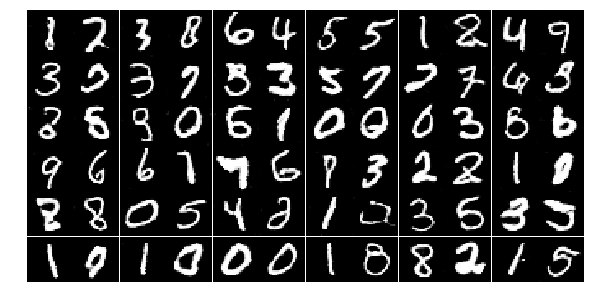

Epoch 22/30... Discriminator Loss: 0.3031... Generator Loss: 1.9285
Epoch 22/30... Discriminator Loss: 0.5645... Generator Loss: 1.4393
Epoch 22/30... Discriminator Loss: 1.0605... Generator Loss: 0.6893
Epoch 22/30... Discriminator Loss: 1.0974... Generator Loss: 0.6204
Epoch 22/30... Discriminator Loss: 0.7546... Generator Loss: 2.6014
Epoch 22/30... Discriminator Loss: 0.5729... Generator Loss: 1.2361
Epoch 22/30... Discriminator Loss: 0.3758... Generator Loss: 1.7850
Epoch 22/30... Discriminator Loss: 0.7955... Generator Loss: 0.8762
Epoch 22/30... Discriminator Loss: 0.4428... Generator Loss: 1.6507
Epoch 22/30... Discriminator Loss: 1.7888... Generator Loss: 0.2851


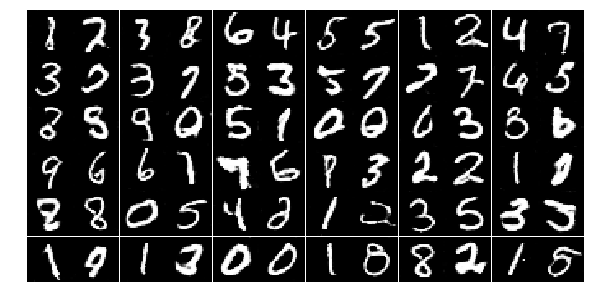

Epoch 22/30... Discriminator Loss: 0.5243... Generator Loss: 1.3814
Epoch 22/30... Discriminator Loss: 1.5577... Generator Loss: 0.4733
Epoch 22/30... Discriminator Loss: 0.6603... Generator Loss: 2.9338
Epoch 22/30... Discriminator Loss: 0.4819... Generator Loss: 1.6058
Epoch 22/30... Discriminator Loss: 0.6951... Generator Loss: 1.1283
Epoch 22/30... Discriminator Loss: 1.1791... Generator Loss: 0.5708
Epoch 22/30... Discriminator Loss: 0.6099... Generator Loss: 1.1756
Epoch 22/30... Discriminator Loss: 0.5520... Generator Loss: 1.2915
Epoch 22/30... Discriminator Loss: 0.7349... Generator Loss: 0.9911
Epoch 22/30... Discriminator Loss: 1.0842... Generator Loss: 0.6575


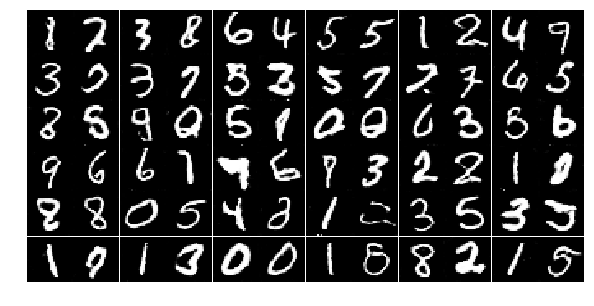

Epoch 22/30... Discriminator Loss: 0.6480... Generator Loss: 1.1276
Epoch 22/30... Discriminator Loss: 0.9453... Generator Loss: 0.7385
Epoch 22/30... Discriminator Loss: 1.3028... Generator Loss: 0.4631
Epoch 23/30... Discriminator Loss: 0.4859... Generator Loss: 1.5238
Epoch 23/30... Discriminator Loss: 0.3492... Generator Loss: 2.8116
Epoch 23/30... Discriminator Loss: 0.4241... Generator Loss: 2.4975
Epoch 23/30... Discriminator Loss: 0.8015... Generator Loss: 0.9572
Epoch 23/30... Discriminator Loss: 1.2212... Generator Loss: 0.5590
Epoch 23/30... Discriminator Loss: 0.4502... Generator Loss: 2.0384
Epoch 23/30... Discriminator Loss: 0.5726... Generator Loss: 4.0811


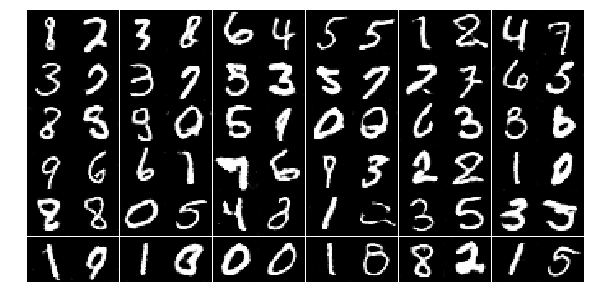

Epoch 23/30... Discriminator Loss: 0.3698... Generator Loss: 1.6900
Epoch 23/30... Discriminator Loss: 1.2264... Generator Loss: 0.5553
Epoch 23/30... Discriminator Loss: 1.1055... Generator Loss: 0.6347
Epoch 23/30... Discriminator Loss: 0.7964... Generator Loss: 0.8236
Epoch 23/30... Discriminator Loss: 0.3369... Generator Loss: 3.1921
Epoch 23/30... Discriminator Loss: 0.8824... Generator Loss: 0.7805
Epoch 23/30... Discriminator Loss: 1.2223... Generator Loss: 0.5626
Epoch 23/30... Discriminator Loss: 0.5949... Generator Loss: 1.1593
Epoch 23/30... Discriminator Loss: 0.5125... Generator Loss: 1.3606
Epoch 23/30... Discriminator Loss: 0.8265... Generator Loss: 0.8303


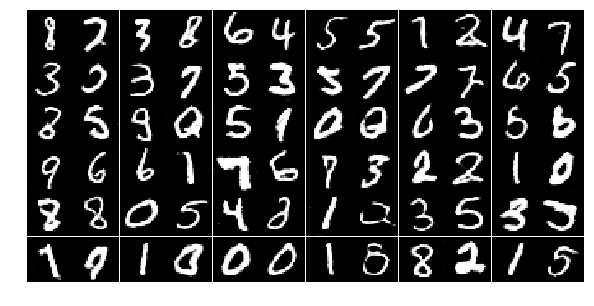

Epoch 23/30... Discriminator Loss: 0.5680... Generator Loss: 1.2557
Epoch 23/30... Discriminator Loss: 0.6855... Generator Loss: 0.9872
Epoch 23/30... Discriminator Loss: 1.0237... Generator Loss: 0.7008
Epoch 23/30... Discriminator Loss: 0.7145... Generator Loss: 1.1218
Epoch 23/30... Discriminator Loss: 0.4803... Generator Loss: 1.3197
Epoch 23/30... Discriminator Loss: 1.2678... Generator Loss: 0.5246
Epoch 23/30... Discriminator Loss: 0.7023... Generator Loss: 0.9864
Epoch 23/30... Discriminator Loss: 0.3645... Generator Loss: 2.8284
Epoch 23/30... Discriminator Loss: 1.5588... Generator Loss: 6.1375
Epoch 23/30... Discriminator Loss: 0.7847... Generator Loss: 0.9944


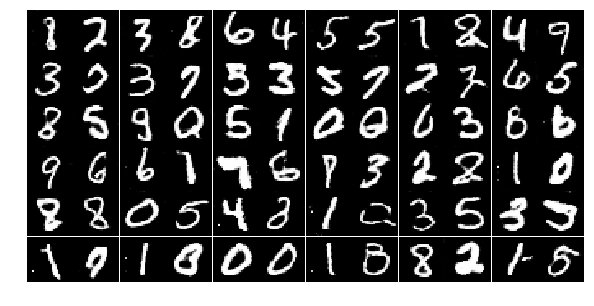

Epoch 23/30... Discriminator Loss: 0.4859... Generator Loss: 1.3730
Epoch 23/30... Discriminator Loss: 1.4574... Generator Loss: 5.4039
Epoch 23/30... Discriminator Loss: 0.4036... Generator Loss: 2.2914
Epoch 23/30... Discriminator Loss: 0.5097... Generator Loss: 1.5552
Epoch 23/30... Discriminator Loss: 0.4759... Generator Loss: 2.1492
Epoch 23/30... Discriminator Loss: 0.6352... Generator Loss: 1.1246
Epoch 23/30... Discriminator Loss: 0.3068... Generator Loss: 2.0019
Epoch 23/30... Discriminator Loss: 0.4836... Generator Loss: 1.7015
Epoch 23/30... Discriminator Loss: 0.8283... Generator Loss: 0.9586
Epoch 23/30... Discriminator Loss: 0.5744... Generator Loss: 1.2340


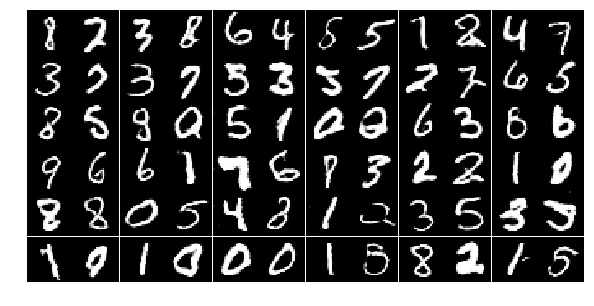

Epoch 23/30... Discriminator Loss: 0.8915... Generator Loss: 0.8311
Epoch 23/30... Discriminator Loss: 0.6103... Generator Loss: 1.0958
Epoch 23/30... Discriminator Loss: 0.3266... Generator Loss: 1.7689
Epoch 23/30... Discriminator Loss: 0.6565... Generator Loss: 1.0631
Epoch 23/30... Discriminator Loss: 0.5736... Generator Loss: 2.2322
Epoch 23/30... Discriminator Loss: 0.8074... Generator Loss: 0.9261
Epoch 24/30... Discriminator Loss: 0.4375... Generator Loss: 2.4858
Epoch 24/30... Discriminator Loss: 1.3090... Generator Loss: 3.3362
Epoch 24/30... Discriminator Loss: 0.8036... Generator Loss: 0.8958
Epoch 24/30... Discriminator Loss: 1.1950... Generator Loss: 0.5316


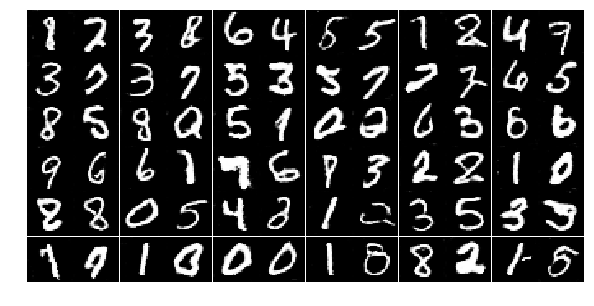

Epoch 24/30... Discriminator Loss: 0.3587... Generator Loss: 2.2700
Epoch 24/30... Discriminator Loss: 0.5238... Generator Loss: 1.4786
Epoch 24/30... Discriminator Loss: 0.9038... Generator Loss: 0.8230
Epoch 24/30... Discriminator Loss: 1.4361... Generator Loss: 0.4836
Epoch 24/30... Discriminator Loss: 0.6739... Generator Loss: 1.0275
Epoch 24/30... Discriminator Loss: 1.3222... Generator Loss: 0.4946
Epoch 24/30... Discriminator Loss: 0.6543... Generator Loss: 1.0854
Epoch 24/30... Discriminator Loss: 0.7416... Generator Loss: 3.0374
Epoch 24/30... Discriminator Loss: 1.0572... Generator Loss: 0.6688
Epoch 24/30... Discriminator Loss: 0.4723... Generator Loss: 1.4011


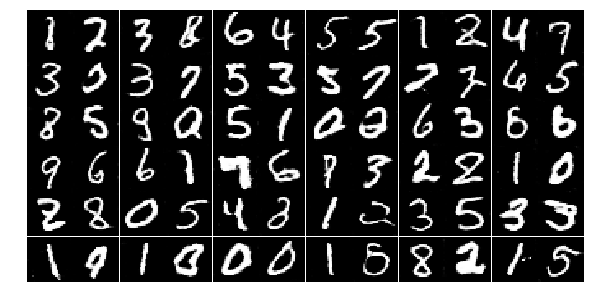

Epoch 24/30... Discriminator Loss: 0.5148... Generator Loss: 1.3260
Epoch 24/30... Discriminator Loss: 0.4462... Generator Loss: 1.8106
Epoch 24/30... Discriminator Loss: 0.6332... Generator Loss: 1.4688
Epoch 24/30... Discriminator Loss: 0.9576... Generator Loss: 0.6869
Epoch 24/30... Discriminator Loss: 0.4836... Generator Loss: 1.3882
Epoch 24/30... Discriminator Loss: 0.3991... Generator Loss: 2.2951
Epoch 24/30... Discriminator Loss: 0.3707... Generator Loss: 1.7908
Epoch 24/30... Discriminator Loss: 1.0079... Generator Loss: 0.7015
Epoch 24/30... Discriminator Loss: 0.9290... Generator Loss: 0.7483
Epoch 24/30... Discriminator Loss: 1.3798... Generator Loss: 0.4536


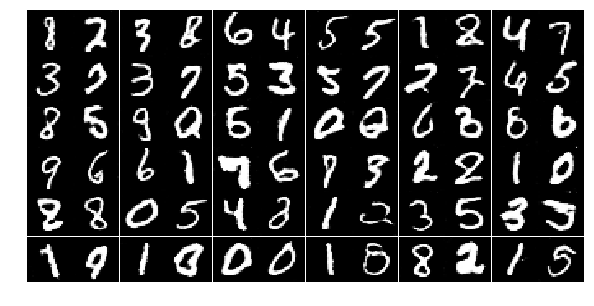

Epoch 24/30... Discriminator Loss: 0.5116... Generator Loss: 1.3884
Epoch 24/30... Discriminator Loss: 1.3445... Generator Loss: 0.4457
Epoch 24/30... Discriminator Loss: 0.6734... Generator Loss: 1.0412
Epoch 24/30... Discriminator Loss: 1.1009... Generator Loss: 0.6313
Epoch 24/30... Discriminator Loss: 0.8609... Generator Loss: 0.8701
Epoch 24/30... Discriminator Loss: 1.2231... Generator Loss: 4.6764
Epoch 24/30... Discriminator Loss: 0.6045... Generator Loss: 1.1905
Epoch 24/30... Discriminator Loss: 2.8488... Generator Loss: 0.1755
Epoch 24/30... Discriminator Loss: 0.8111... Generator Loss: 0.8956
Epoch 24/30... Discriminator Loss: 0.5188... Generator Loss: 1.4993


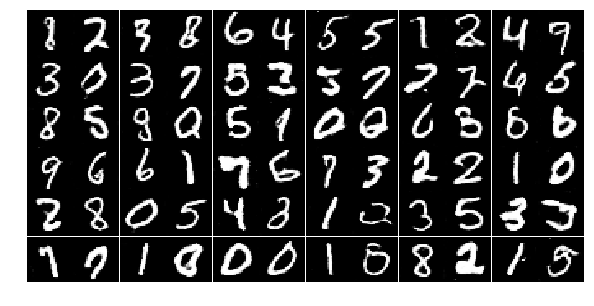

Epoch 24/30... Discriminator Loss: 0.6609... Generator Loss: 1.1614
Epoch 24/30... Discriminator Loss: 0.5951... Generator Loss: 2.2392
Epoch 24/30... Discriminator Loss: 2.2546... Generator Loss: 0.1989
Epoch 24/30... Discriminator Loss: 0.6238... Generator Loss: 1.9405
Epoch 24/30... Discriminator Loss: 0.3538... Generator Loss: 2.1809
Epoch 24/30... Discriminator Loss: 0.4916... Generator Loss: 1.5497
Epoch 24/30... Discriminator Loss: 1.2937... Generator Loss: 0.4459
Epoch 24/30... Discriminator Loss: 0.5099... Generator Loss: 1.5039
Epoch 24/30... Discriminator Loss: 0.9926... Generator Loss: 0.6214
Epoch 25/30... Discriminator Loss: 0.5647... Generator Loss: 1.2350


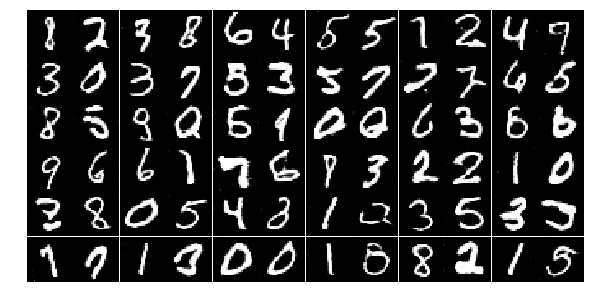

Epoch 25/30... Discriminator Loss: 0.8206... Generator Loss: 0.8243
Epoch 25/30... Discriminator Loss: 0.7061... Generator Loss: 0.9998
Epoch 25/30... Discriminator Loss: 0.9430... Generator Loss: 0.7382
Epoch 25/30... Discriminator Loss: 0.3643... Generator Loss: 1.8603
Epoch 25/30... Discriminator Loss: 0.8628... Generator Loss: 2.7908
Epoch 25/30... Discriminator Loss: 0.5504... Generator Loss: 1.6884
Epoch 25/30... Discriminator Loss: 0.6232... Generator Loss: 1.1212
Epoch 25/30... Discriminator Loss: 0.6526... Generator Loss: 1.1024
Epoch 25/30... Discriminator Loss: 0.7497... Generator Loss: 1.2296
Epoch 25/30... Discriminator Loss: 0.4381... Generator Loss: 1.5312


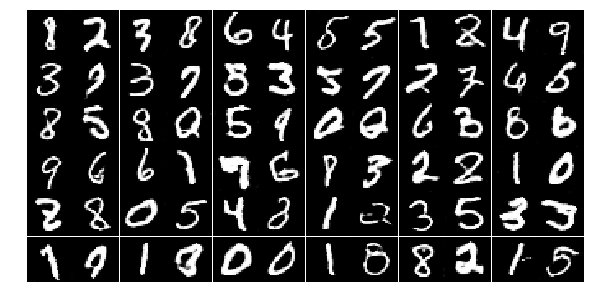

Epoch 25/30... Discriminator Loss: 0.8556... Generator Loss: 0.7734
Epoch 25/30... Discriminator Loss: 0.8243... Generator Loss: 0.9124
Epoch 25/30... Discriminator Loss: 0.9338... Generator Loss: 0.7303
Epoch 25/30... Discriminator Loss: 0.9814... Generator Loss: 0.7184
Epoch 25/30... Discriminator Loss: 0.6650... Generator Loss: 1.0118
Epoch 25/30... Discriminator Loss: 0.9004... Generator Loss: 0.7769
Epoch 25/30... Discriminator Loss: 0.5111... Generator Loss: 1.3068
Epoch 25/30... Discriminator Loss: 0.7407... Generator Loss: 0.8995
Epoch 25/30... Discriminator Loss: 0.3941... Generator Loss: 1.5711
Epoch 25/30... Discriminator Loss: 0.8282... Generator Loss: 0.8235


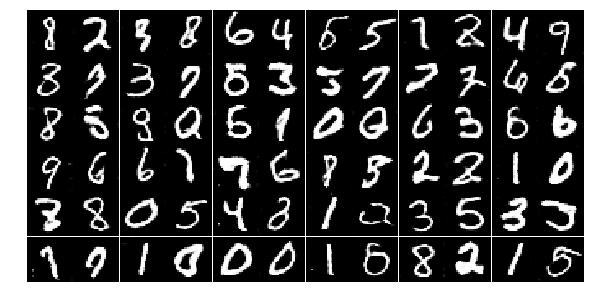

Epoch 25/30... Discriminator Loss: 0.3526... Generator Loss: 1.7903
Epoch 25/30... Discriminator Loss: 0.9863... Generator Loss: 0.6671
Epoch 25/30... Discriminator Loss: 0.4637... Generator Loss: 2.0986
Epoch 25/30... Discriminator Loss: 1.5938... Generator Loss: 0.5050
Epoch 25/30... Discriminator Loss: 0.7214... Generator Loss: 0.9783
Epoch 25/30... Discriminator Loss: 0.6606... Generator Loss: 1.1063
Epoch 25/30... Discriminator Loss: 1.1561... Generator Loss: 0.6115
Epoch 25/30... Discriminator Loss: 0.6714... Generator Loss: 1.0723
Epoch 25/30... Discriminator Loss: 0.5049... Generator Loss: 2.3207
Epoch 25/30... Discriminator Loss: 0.5989... Generator Loss: 1.2598


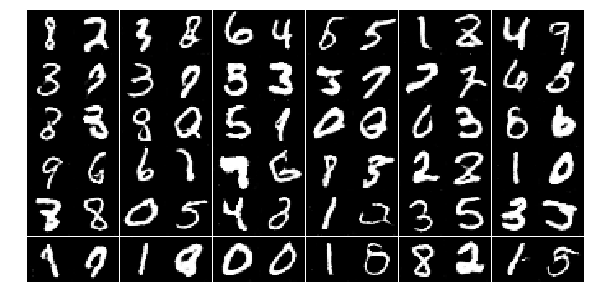

Epoch 25/30... Discriminator Loss: 0.5433... Generator Loss: 1.3427
Epoch 25/30... Discriminator Loss: 1.2128... Generator Loss: 0.5366
Epoch 25/30... Discriminator Loss: 0.4565... Generator Loss: 1.9675
Epoch 25/30... Discriminator Loss: 0.5444... Generator Loss: 1.2643
Epoch 25/30... Discriminator Loss: 0.6148... Generator Loss: 1.3771
Epoch 25/30... Discriminator Loss: 1.1087... Generator Loss: 0.5770
Epoch 25/30... Discriminator Loss: 0.8519... Generator Loss: 0.8430
Epoch 25/30... Discriminator Loss: 0.5943... Generator Loss: 1.1698
Epoch 25/30... Discriminator Loss: 0.6468... Generator Loss: 1.0245
Epoch 25/30... Discriminator Loss: 0.3281... Generator Loss: 2.2727


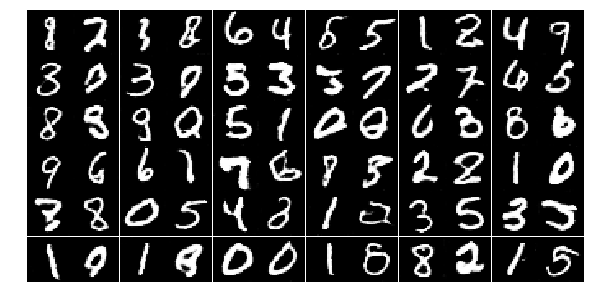

Epoch 25/30... Discriminator Loss: 0.8699... Generator Loss: 0.7650
Epoch 25/30... Discriminator Loss: 0.7216... Generator Loss: 0.9303
Epoch 26/30... Discriminator Loss: 0.8412... Generator Loss: 3.3923
Epoch 26/30... Discriminator Loss: 0.8283... Generator Loss: 0.8982
Epoch 26/30... Discriminator Loss: 0.4359... Generator Loss: 1.6634
Epoch 26/30... Discriminator Loss: 0.8373... Generator Loss: 0.8878
Epoch 26/30... Discriminator Loss: 1.1260... Generator Loss: 0.6344
Epoch 26/30... Discriminator Loss: 0.4699... Generator Loss: 1.5753
Epoch 26/30... Discriminator Loss: 0.8607... Generator Loss: 0.8429
Epoch 26/30... Discriminator Loss: 1.4114... Generator Loss: 0.4503


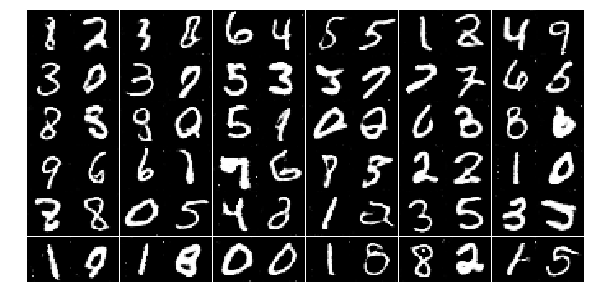

Epoch 26/30... Discriminator Loss: 0.5622... Generator Loss: 1.3454
Epoch 26/30... Discriminator Loss: 0.4913... Generator Loss: 1.7878
Epoch 26/30... Discriminator Loss: 0.4437... Generator Loss: 2.0480
Epoch 26/30... Discriminator Loss: 0.4881... Generator Loss: 1.8837
Epoch 26/30... Discriminator Loss: 0.6400... Generator Loss: 1.0377
Epoch 26/30... Discriminator Loss: 1.4185... Generator Loss: 0.4329
Epoch 26/30... Discriminator Loss: 0.9371... Generator Loss: 4.1075
Epoch 26/30... Discriminator Loss: 0.8671... Generator Loss: 0.7658
Epoch 26/30... Discriminator Loss: 0.8625... Generator Loss: 0.8386
Epoch 26/30... Discriminator Loss: 0.7760... Generator Loss: 1.0345


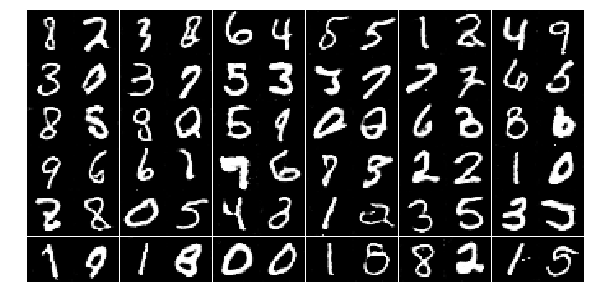

Epoch 26/30... Discriminator Loss: 1.1838... Generator Loss: 0.5901
Epoch 26/30... Discriminator Loss: 0.7578... Generator Loss: 0.8865
Epoch 26/30... Discriminator Loss: 0.4106... Generator Loss: 3.3835
Epoch 26/30... Discriminator Loss: 0.9835... Generator Loss: 0.7228
Epoch 26/30... Discriminator Loss: 0.7205... Generator Loss: 0.9751
Epoch 26/30... Discriminator Loss: 0.5201... Generator Loss: 1.3850
Epoch 26/30... Discriminator Loss: 1.2468... Generator Loss: 4.8938
Epoch 26/30... Discriminator Loss: 0.7224... Generator Loss: 0.9541
Epoch 26/30... Discriminator Loss: 0.9761... Generator Loss: 0.7117
Epoch 26/30... Discriminator Loss: 0.9866... Generator Loss: 0.7664


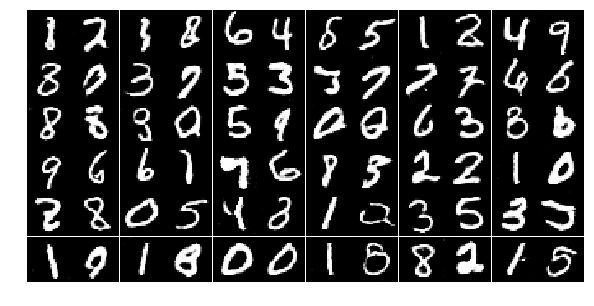

Epoch 26/30... Discriminator Loss: 0.7140... Generator Loss: 1.0491
Epoch 26/30... Discriminator Loss: 1.4721... Generator Loss: 0.3960
Epoch 26/30... Discriminator Loss: 1.2017... Generator Loss: 0.5753
Epoch 26/30... Discriminator Loss: 0.8274... Generator Loss: 0.8051
Epoch 26/30... Discriminator Loss: 0.3162... Generator Loss: 1.8539
Epoch 26/30... Discriminator Loss: 0.7772... Generator Loss: 0.8643
Epoch 26/30... Discriminator Loss: 0.8224... Generator Loss: 0.8391
Epoch 26/30... Discriminator Loss: 0.5180... Generator Loss: 1.2394
Epoch 26/30... Discriminator Loss: 0.8875... Generator Loss: 0.7638
Epoch 26/30... Discriminator Loss: 1.1265... Generator Loss: 0.6274


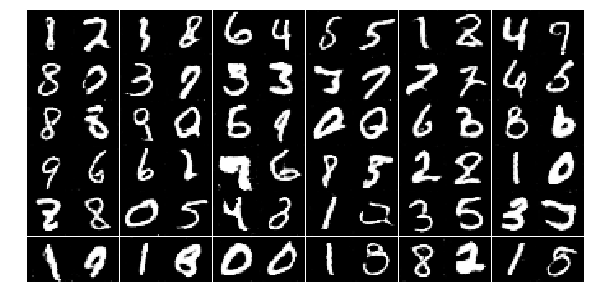

Epoch 26/30... Discriminator Loss: 1.1754... Generator Loss: 0.6909
Epoch 26/30... Discriminator Loss: 0.6861... Generator Loss: 1.0596
Epoch 26/30... Discriminator Loss: 0.6105... Generator Loss: 1.0928
Epoch 26/30... Discriminator Loss: 0.8776... Generator Loss: 0.7854
Epoch 26/30... Discriminator Loss: 0.7590... Generator Loss: 0.9833
Epoch 27/30... Discriminator Loss: 0.8426... Generator Loss: 0.7883
Epoch 27/30... Discriminator Loss: 0.8524... Generator Loss: 0.8140
Epoch 27/30... Discriminator Loss: 0.8940... Generator Loss: 0.7714
Epoch 27/30... Discriminator Loss: 0.4677... Generator Loss: 1.4390
Epoch 27/30... Discriminator Loss: 0.6415... Generator Loss: 1.1231


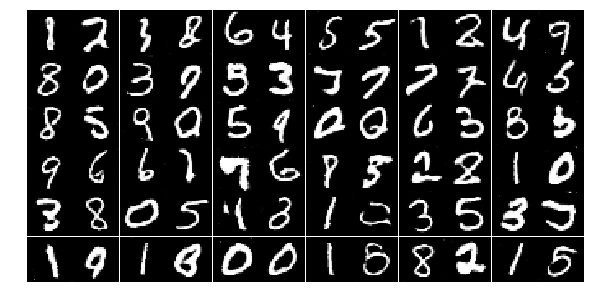

Epoch 27/30... Discriminator Loss: 0.9124... Generator Loss: 0.7348
Epoch 27/30... Discriminator Loss: 0.4036... Generator Loss: 1.5978
Epoch 27/30... Discriminator Loss: 0.8621... Generator Loss: 0.8611
Epoch 27/30... Discriminator Loss: 0.7105... Generator Loss: 0.9330
Epoch 27/30... Discriminator Loss: 0.5550... Generator Loss: 1.2146
Epoch 27/30... Discriminator Loss: 1.1651... Generator Loss: 0.5800
Epoch 27/30... Discriminator Loss: 0.4831... Generator Loss: 1.3936
Epoch 27/30... Discriminator Loss: 1.7112... Generator Loss: 0.3064
Epoch 27/30... Discriminator Loss: 0.6676... Generator Loss: 1.0411
Epoch 27/30... Discriminator Loss: 0.6988... Generator Loss: 1.0624


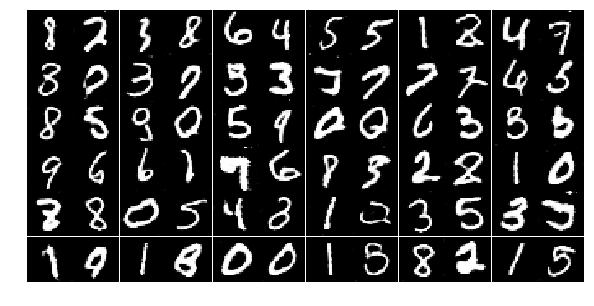

Epoch 27/30... Discriminator Loss: 3.0186... Generator Loss: 0.1115
Epoch 27/30... Discriminator Loss: 1.4904... Generator Loss: 5.4085
Epoch 27/30... Discriminator Loss: 0.7199... Generator Loss: 1.1480
Epoch 27/30... Discriminator Loss: 1.4609... Generator Loss: 0.4441
Epoch 27/30... Discriminator Loss: 0.6176... Generator Loss: 2.1212
Epoch 27/30... Discriminator Loss: 1.0562... Generator Loss: 0.6462
Epoch 27/30... Discriminator Loss: 0.7032... Generator Loss: 1.0497
Epoch 27/30... Discriminator Loss: 0.4991... Generator Loss: 1.3634
Epoch 27/30... Discriminator Loss: 0.8200... Generator Loss: 0.8592
Epoch 27/30... Discriminator Loss: 0.4898... Generator Loss: 1.5670


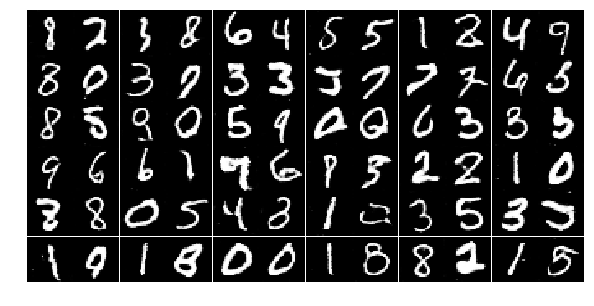

Epoch 27/30... Discriminator Loss: 0.8262... Generator Loss: 0.9031
Epoch 27/30... Discriminator Loss: 0.6594... Generator Loss: 1.2397
Epoch 27/30... Discriminator Loss: 0.5813... Generator Loss: 1.2480
Epoch 27/30... Discriminator Loss: 0.6108... Generator Loss: 1.2135
Epoch 27/30... Discriminator Loss: 0.6240... Generator Loss: 1.4071
Epoch 27/30... Discriminator Loss: 1.5885... Generator Loss: 0.4247
Epoch 27/30... Discriminator Loss: 0.5316... Generator Loss: 1.2747
Epoch 27/30... Discriminator Loss: 0.9600... Generator Loss: 0.6935
Epoch 27/30... Discriminator Loss: 0.6847... Generator Loss: 1.0633
Epoch 27/30... Discriminator Loss: 0.8418... Generator Loss: 0.8206


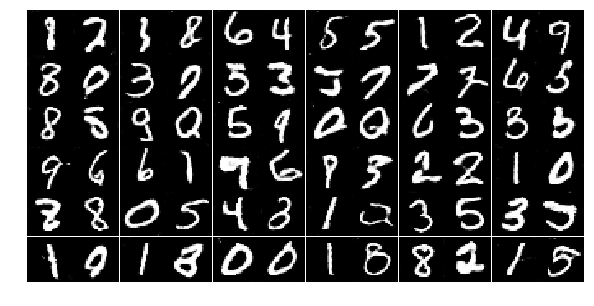

Epoch 27/30... Discriminator Loss: 1.4581... Generator Loss: 0.4368
Epoch 27/30... Discriminator Loss: 0.6781... Generator Loss: 1.0601
Epoch 27/30... Discriminator Loss: 0.5857... Generator Loss: 1.1977
Epoch 27/30... Discriminator Loss: 1.0418... Generator Loss: 0.6698
Epoch 27/30... Discriminator Loss: 1.7979... Generator Loss: 0.4193
Epoch 27/30... Discriminator Loss: 1.2762... Generator Loss: 0.5296
Epoch 27/30... Discriminator Loss: 0.5601... Generator Loss: 1.5150
Epoch 27/30... Discriminator Loss: 1.1571... Generator Loss: 0.5844
Epoch 28/30... Discriminator Loss: 0.5552... Generator Loss: 2.2513
Epoch 28/30... Discriminator Loss: 1.7096... Generator Loss: 0.3206


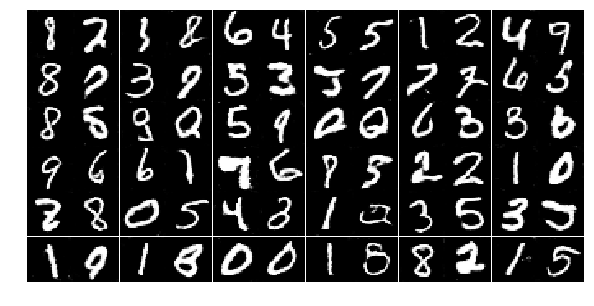

Epoch 28/30... Discriminator Loss: 0.4803... Generator Loss: 2.4109
Epoch 28/30... Discriminator Loss: 0.5651... Generator Loss: 1.2268
Epoch 28/30... Discriminator Loss: 0.6709... Generator Loss: 1.0009
Epoch 28/30... Discriminator Loss: 0.8986... Generator Loss: 0.8034
Epoch 28/30... Discriminator Loss: 0.5706... Generator Loss: 1.1792
Epoch 28/30... Discriminator Loss: 0.7858... Generator Loss: 0.8972
Epoch 28/30... Discriminator Loss: 1.4016... Generator Loss: 0.4911
Epoch 28/30... Discriminator Loss: 1.4825... Generator Loss: 0.4689
Epoch 28/30... Discriminator Loss: 0.8500... Generator Loss: 0.9404
Epoch 28/30... Discriminator Loss: 0.4684... Generator Loss: 1.5646


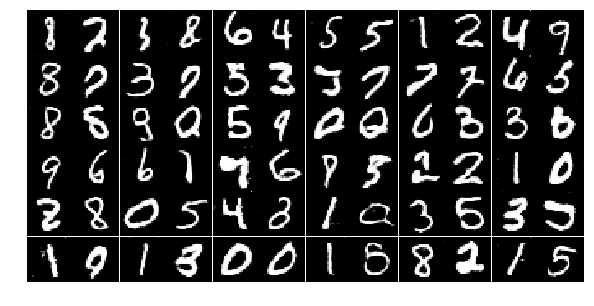

Epoch 28/30... Discriminator Loss: 1.2357... Generator Loss: 0.5998
Epoch 28/30... Discriminator Loss: 0.4753... Generator Loss: 2.1508
Epoch 28/30... Discriminator Loss: 0.8890... Generator Loss: 2.4706
Epoch 28/30... Discriminator Loss: 1.1809... Generator Loss: 0.6199
Epoch 28/30... Discriminator Loss: 0.5156... Generator Loss: 1.4281
Epoch 28/30... Discriminator Loss: 0.7998... Generator Loss: 0.9544
Epoch 28/30... Discriminator Loss: 0.7580... Generator Loss: 0.9727
Epoch 28/30... Discriminator Loss: 0.8673... Generator Loss: 0.7432
Epoch 28/30... Discriminator Loss: 1.3653... Generator Loss: 0.4610
Epoch 28/30... Discriminator Loss: 0.6406... Generator Loss: 1.0606


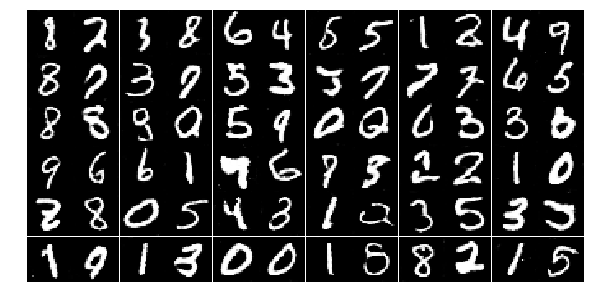

Epoch 28/30... Discriminator Loss: 0.9753... Generator Loss: 0.7957
Epoch 28/30... Discriminator Loss: 0.6499... Generator Loss: 1.1217
Epoch 28/30... Discriminator Loss: 1.0458... Generator Loss: 0.7071
Epoch 28/30... Discriminator Loss: 0.5093... Generator Loss: 1.3602
Epoch 28/30... Discriminator Loss: 0.5107... Generator Loss: 1.3775
Epoch 28/30... Discriminator Loss: 0.6257... Generator Loss: 1.1166
Epoch 28/30... Discriminator Loss: 1.4629... Generator Loss: 0.4306
Epoch 28/30... Discriminator Loss: 0.4695... Generator Loss: 1.6041
Epoch 28/30... Discriminator Loss: 0.8898... Generator Loss: 0.9811
Epoch 28/30... Discriminator Loss: 0.7241... Generator Loss: 1.0383


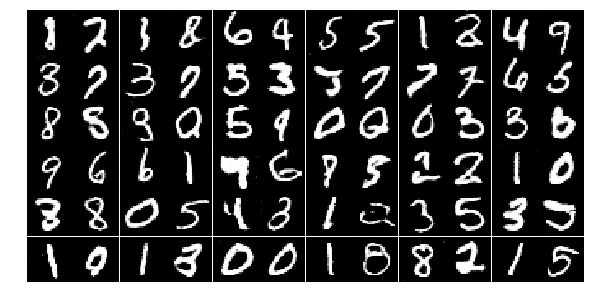

Epoch 28/30... Discriminator Loss: 0.5380... Generator Loss: 1.3562
Epoch 28/30... Discriminator Loss: 0.7881... Generator Loss: 0.8752
Epoch 28/30... Discriminator Loss: 0.5647... Generator Loss: 1.2657
Epoch 28/30... Discriminator Loss: 0.9402... Generator Loss: 0.7998
Epoch 28/30... Discriminator Loss: 1.0866... Generator Loss: 0.6153
Epoch 28/30... Discriminator Loss: 0.7272... Generator Loss: 0.9528
Epoch 28/30... Discriminator Loss: 0.7433... Generator Loss: 1.2182
Epoch 28/30... Discriminator Loss: 0.8459... Generator Loss: 0.9379
Epoch 28/30... Discriminator Loss: 0.4947... Generator Loss: 1.6939
Epoch 28/30... Discriminator Loss: 0.6575... Generator Loss: 1.2741


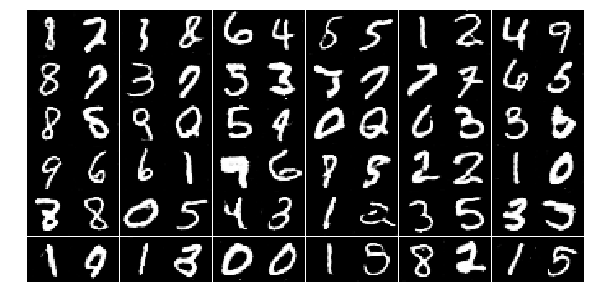

Epoch 28/30... Discriminator Loss: 0.9341... Generator Loss: 0.7404
Epoch 29/30... Discriminator Loss: 0.7462... Generator Loss: 1.1933
Epoch 29/30... Discriminator Loss: 0.5674... Generator Loss: 1.5915
Epoch 29/30... Discriminator Loss: 0.9433... Generator Loss: 0.6775
Epoch 29/30... Discriminator Loss: 0.3792... Generator Loss: 1.7984
Epoch 29/30... Discriminator Loss: 0.4545... Generator Loss: 1.8198
Epoch 29/30... Discriminator Loss: 0.3553... Generator Loss: 2.8760
Epoch 29/30... Discriminator Loss: 0.8280... Generator Loss: 0.8502
Epoch 29/30... Discriminator Loss: 0.4680... Generator Loss: 1.4742
Epoch 29/30... Discriminator Loss: 0.7790... Generator Loss: 0.8899


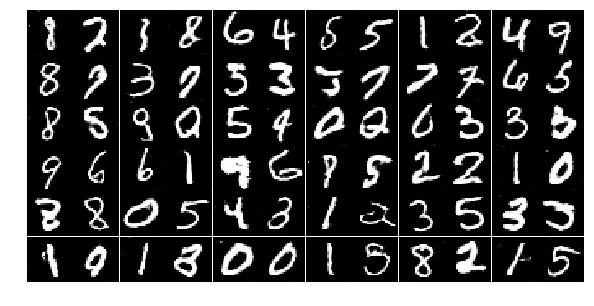

Epoch 29/30... Discriminator Loss: 0.5799... Generator Loss: 1.2516
Epoch 29/30... Discriminator Loss: 1.2648... Generator Loss: 0.5012
Epoch 29/30... Discriminator Loss: 0.3518... Generator Loss: 2.0727
Epoch 29/30... Discriminator Loss: 0.4361... Generator Loss: 1.7448
Epoch 29/30... Discriminator Loss: 0.6180... Generator Loss: 1.8747
Epoch 29/30... Discriminator Loss: 0.6531... Generator Loss: 1.1015
Epoch 29/30... Discriminator Loss: 0.6672... Generator Loss: 1.0704
Epoch 29/30... Discriminator Loss: 1.5401... Generator Loss: 0.3911
Epoch 29/30... Discriminator Loss: 0.6533... Generator Loss: 1.1454
Epoch 29/30... Discriminator Loss: 0.6291... Generator Loss: 1.1419


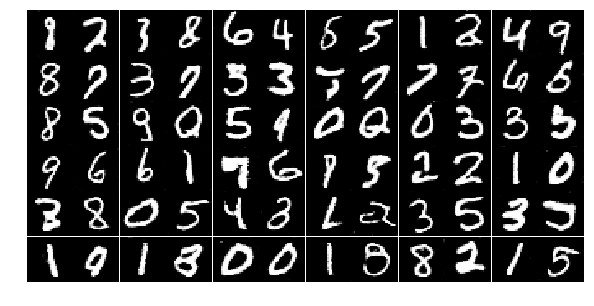

Epoch 29/30... Discriminator Loss: 0.4351... Generator Loss: 1.6587
Epoch 29/30... Discriminator Loss: 0.7387... Generator Loss: 0.9259
Epoch 29/30... Discriminator Loss: 1.4096... Generator Loss: 0.4820
Epoch 29/30... Discriminator Loss: 0.8747... Generator Loss: 0.8147
Epoch 29/30... Discriminator Loss: 0.8684... Generator Loss: 0.7889
Epoch 29/30... Discriminator Loss: 0.5630... Generator Loss: 1.1997
Epoch 29/30... Discriminator Loss: 0.7341... Generator Loss: 1.0280
Epoch 29/30... Discriminator Loss: 0.9233... Generator Loss: 0.8023
Epoch 29/30... Discriminator Loss: 0.6282... Generator Loss: 1.4465
Epoch 29/30... Discriminator Loss: 0.7428... Generator Loss: 1.0058


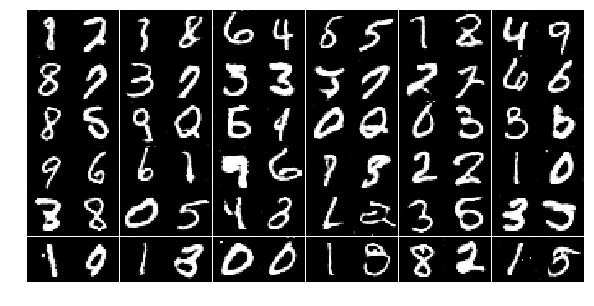

Epoch 29/30... Discriminator Loss: 1.2533... Generator Loss: 0.5773
Epoch 29/30... Discriminator Loss: 1.1251... Generator Loss: 0.6393
Epoch 29/30... Discriminator Loss: 1.4896... Generator Loss: 0.4829
Epoch 29/30... Discriminator Loss: 0.7464... Generator Loss: 3.2577
Epoch 29/30... Discriminator Loss: 0.7670... Generator Loss: 3.1507
Epoch 29/30... Discriminator Loss: 1.0242... Generator Loss: 0.6887
Epoch 29/30... Discriminator Loss: 0.5788... Generator Loss: 2.1155
Epoch 29/30... Discriminator Loss: 1.0618... Generator Loss: 0.6736
Epoch 29/30... Discriminator Loss: 0.5616... Generator Loss: 2.8519
Epoch 29/30... Discriminator Loss: 0.7678... Generator Loss: 1.0213


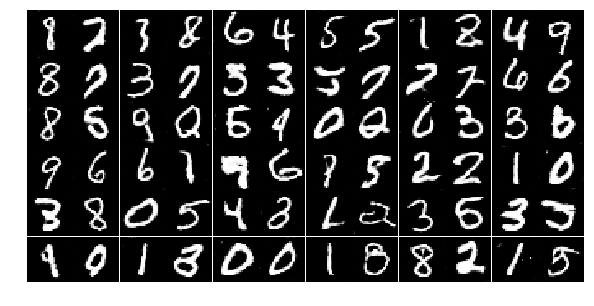

Epoch 29/30... Discriminator Loss: 0.6092... Generator Loss: 1.2412
Epoch 29/30... Discriminator Loss: 0.6936... Generator Loss: 1.0473
Epoch 29/30... Discriminator Loss: 1.0110... Generator Loss: 0.6764
Epoch 29/30... Discriminator Loss: 0.6070... Generator Loss: 1.4111
Epoch 30/30... Discriminator Loss: 0.4125... Generator Loss: 1.8372
Epoch 30/30... Discriminator Loss: 1.2050... Generator Loss: 0.6161
Epoch 30/30... Discriminator Loss: 0.7580... Generator Loss: 0.9781
Epoch 30/30... Discriminator Loss: 0.6576... Generator Loss: 1.0492
Epoch 30/30... Discriminator Loss: 0.5699... Generator Loss: 1.2966
Epoch 30/30... Discriminator Loss: 0.4376... Generator Loss: 2.9123


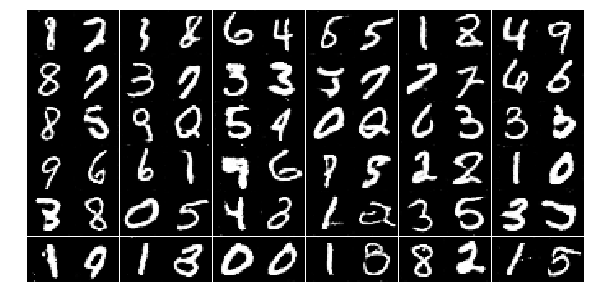

Epoch 30/30... Discriminator Loss: 0.3370... Generator Loss: 2.1519
Epoch 30/30... Discriminator Loss: 0.4457... Generator Loss: 1.5549
Epoch 30/30... Discriminator Loss: 0.5519... Generator Loss: 1.2757
Epoch 30/30... Discriminator Loss: 1.0562... Generator Loss: 0.6329
Epoch 30/30... Discriminator Loss: 0.7464... Generator Loss: 0.9244
Epoch 30/30... Discriminator Loss: 0.7993... Generator Loss: 0.8779
Epoch 30/30... Discriminator Loss: 1.0268... Generator Loss: 0.7146
Epoch 30/30... Discriminator Loss: 0.6503... Generator Loss: 1.1701
Epoch 30/30... Discriminator Loss: 0.6906... Generator Loss: 1.0327
Epoch 30/30... Discriminator Loss: 0.8840... Generator Loss: 0.7841


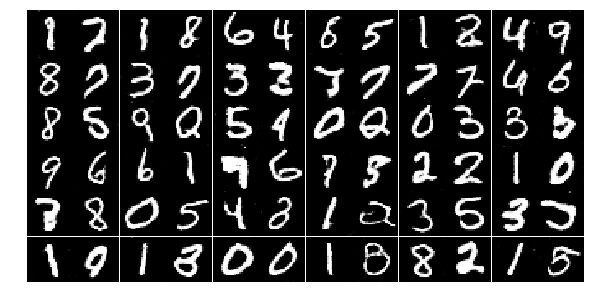

Epoch 30/30... Discriminator Loss: 0.3334... Generator Loss: 2.6048
Epoch 30/30... Discriminator Loss: 0.7509... Generator Loss: 1.0330
Epoch 30/30... Discriminator Loss: 0.7271... Generator Loss: 0.9759
Epoch 30/30... Discriminator Loss: 0.5707... Generator Loss: 1.2492
Epoch 30/30... Discriminator Loss: 0.6080... Generator Loss: 1.2336
Epoch 30/30... Discriminator Loss: 0.7300... Generator Loss: 1.0360
Epoch 30/30... Discriminator Loss: 0.9636... Generator Loss: 0.7189
Epoch 30/30... Discriminator Loss: 0.9565... Generator Loss: 0.6892
Epoch 30/30... Discriminator Loss: 1.4468... Generator Loss: 0.4163
Epoch 30/30... Discriminator Loss: 1.1596... Generator Loss: 0.6387


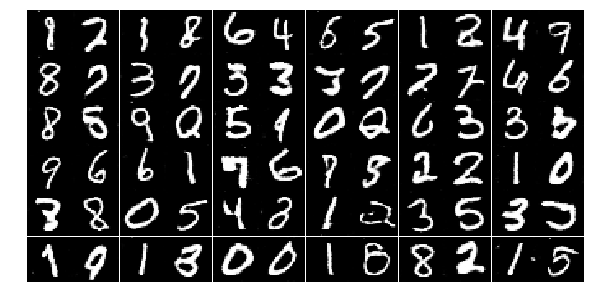

Epoch 30/30... Discriminator Loss: 0.7836... Generator Loss: 0.9778
Epoch 30/30... Discriminator Loss: 1.0671... Generator Loss: 0.6352
Epoch 30/30... Discriminator Loss: 0.4802... Generator Loss: 1.5337
Epoch 30/30... Discriminator Loss: 0.4486... Generator Loss: 1.4850
Epoch 30/30... Discriminator Loss: 0.3344... Generator Loss: 1.9305
Epoch 30/30... Discriminator Loss: 0.4691... Generator Loss: 1.4143
Epoch 30/30... Discriminator Loss: 0.6522... Generator Loss: 1.0435
Epoch 30/30... Discriminator Loss: 1.0161... Generator Loss: 0.7814
Epoch 30/30... Discriminator Loss: 0.2861... Generator Loss: 2.1519
Epoch 30/30... Discriminator Loss: 0.7259... Generator Loss: 0.9157


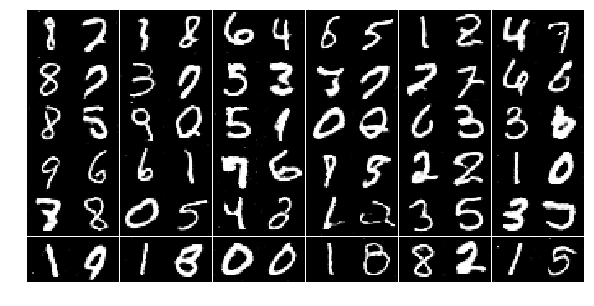

Epoch 30/30... Discriminator Loss: 0.3259... Generator Loss: 1.8928
Epoch 30/30... Discriminator Loss: 0.8451... Generator Loss: 2.2517
Epoch 30/30... Discriminator Loss: 0.7353... Generator Loss: 1.1097
Epoch 30/30... Discriminator Loss: 2.0252... Generator Loss: 0.2938
Epoch 30/30... Discriminator Loss: 0.9561... Generator Loss: 0.7770
Epoch 30/30... Discriminator Loss: 0.5563... Generator Loss: 1.4150
Epoch 30/30... Discriminator Loss: 0.4175... Generator Loss: 1.9838


In [12]:
losses, samples = train(net, epochs, batch_size, figsize=(10,5))

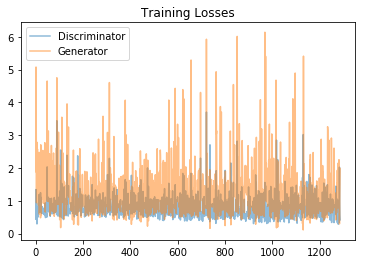

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

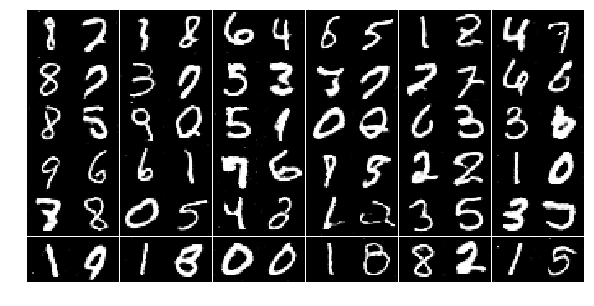

In [14]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))